# Bibliotecas e Leitura dos Dados

In [ ]:
!pip install d3rlpy > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQLConfig
from d3rlpy.preprocessing import StandardObservationScaler, MinMaxActionScaler, MinMaxRewardScaler
from d3rlpy.metrics import TDErrorEvaluator, AverageValueEstimationEvaluator

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_final = pd.read_csv("/content/drive/MyDrive/Conf2/DF_FINAL.csv", index_col='TEMPO')
df_final.index = pd.to_datetime(df_final.index)
df_actions = pd.read_csv("/content/drive/MyDrive/Conf2/DF_ACTION.csv", index_col='TEMPO')
df_actions.index = pd.to_datetime(df_actions.index)
df_reward = pd.read_csv("/content/drive/MyDrive/Conf2/DF_REWARD.csv", index_col='TEMPO')
df_reward.index = pd.to_datetime(df_reward.index)

In [ ]:
class agent:
  def __init__(self, model):
    self.observation_scaler = StandardObservationScaler()
    self.action_scaler = MinMaxActionScaler()
    self.reward_scaler = MinMaxRewardScaler()
    self.td_error_evaluator = TDErrorEvaluator()
    self.ave_value_evaluator = AverageValueEstimationEvaluator()
    self.model = model(observation_scaler=self.observation_scaler,
                       action_scaler=self.action_scaler,
                       reward_scaler=self.reward_scaler).create(device='cuda:0')
    self.is_trained = False

  def set_dataset(self, dataset):
    self.dataset = dataset

  def fitting(self, n_steps, n_steps_per_epoch):
    self.model.fit(
        self.dataset,
        n_steps=n_steps,
        n_steps_per_epoch=n_steps_per_epoch,
        evaluators={
            'td_error': self.td_error_evaluator,
            'ave_value': self.ave_value_evaluator,
        },
    )
    self.is_trained = True

  def predict(self, observations):
    if self.is_trained:
      return self.model.predict(observations)
    else:
      print("Model not trained")
      return None

  def predict_value(self, observations, actions):
    if self.is_trained:
      return self.model.predict_value(observations, actions)
    else:
      print("Model not trained")
      return None

  def save(self, path):
    self.model.save(path)

  def load(self, path):
    self.model = d3rlpy.load_learnable(path)
    self.is_trained = True

In [ ]:
def split_timeseries(array, split_index):
  train = array[:split_index+1]
  test = array[split_index+1:]
  return train, test

# Agentes para cada situação

## Agente da Região Inteira

### 100% de treino

In [ ]:
observations = df_final.values
actions = df_actions["POTENCIA_ATIVA_GERADOR"].values
rewards = df_reward.values
timeouts = np.zeros(len(rewards))
timeouts[1440::1440] = 1
index = df_final.index

In [ ]:
dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=np.zeros(len(rewards)),
    timeouts=timeouts,
)

2024-09-28 19:02.34 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-28 19:02.34 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-28 19:02.34 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
full_agent = agent(CQLConfig)
full_agent.set_dataset(dataset)
n_steps_per_epoch = 10000
epochs = 5
full_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-28 19:02.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-28 19:02.45 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-28 19:02.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-28 19:02.45 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-28 19:02.45 [info     ] Directory is created at d3rlpy_logs/CQL_20240928190245
2024-09-28 19:02.45 [debug    ] Building models...            
2024-09-28 19:02.45 [debug    ] Models have been built.       
2024-09-28 19:02.45 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-28 19:08.45 [info     ] CQL_20240928190245: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.005966621375083923, 'time_algorithm_update': 0.028945966696739198, 'critic_loss': -56.55706027431488, 'conservative_loss': -57.21045263633728, 'alpha': 0.6417360345214606, 'actor_loss': -14.14155188404359, 'temp': 1.6862765225827694, 'temp_loss': -1.2387336852160282, 'time_step': 0.03541370115280151, 'td_error': 0.5301637436680585, 'ave_value': 32.081402455148705} step=10000
2024-09-28 19:08.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240928190245/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-28 19:14.05 [info     ] CQL_20240928190245: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.005263086342811585, 'time_algorithm_update': 0.026018002223968505, 'critic_loss': -22.816058203792572, 'conservative_loss': -23.75941656780243, 'alpha': 0.2574936828508973, 'actor_loss': -30.914048943138123, 'temp': 4.663817142057419, 'temp_loss': -1.6703357082735748, 'time_step': 0.03166644639968872, 'td_error': 0.5706120744730815, 'ave_value': 44.92933604436567} step=20000
2024-09-28 19:14.05 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240928190245/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-28 19:19.06 [info     ] CQL_20240928190245: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.004943855357170105, 'time_algorithm_update': 0.024432662487030028, 'critic_loss': -7.122629991555214, 'conservative_loss': -9.516238069438934, 'alpha': 0.10417484289258719, 'actor_loss': -31.376192622566222, 'temp': 8.184762806415558, 'temp_loss': -0.1533879893535748, 'time_step': 0.029752867603302, 'td_error': 2.1670487387457147, 'ave_value': 41.89095924580767} step=30000
2024-09-28 19:19.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240928190245/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-28 19:24.02 [info     ] CQL_20240928190245: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.004872026634216309, 'time_algorithm_update': 0.024070292139053345, 'critic_loss': 1.0608811109781264, 'conservative_loss': -3.7670930650234222, 'alpha': 0.04220619324278086, 'actor_loss': -29.447759506225587, 'temp': 7.863067093896865, 'temp_loss': 0.03672585472539067, 'time_step': 0.0293139967918396, 'td_error': 2.2072095611058007, 'ave_value': 41.737032172499205} step=40000
2024-09-28 19:24.02 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240928190245/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-28 19:28.57 [info     ] CQL_20240928190245: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.004822737503051758, 'time_algorithm_update': 0.024033841824531554, 'critic_loss': 2.587735751104355, 'conservative_loss': -1.4969210534334183, 'alpha': 0.017095534497685732, 'actor_loss': -32.43474098434448, 'temp': 7.288951353931427, 'temp_loss': 0.028337476344313474, 'time_step': 0.029225158762931823, 'td_error': 1.8423577500165484, 'ave_value': 44.71521057388791} step=50000
2024-09-28 19:28.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240928190245/model_50000.d3


In [ ]:
predict_actions = full_agent.predict(observations)
actions_value = full_agent.predict_value(observations, predict_actions)

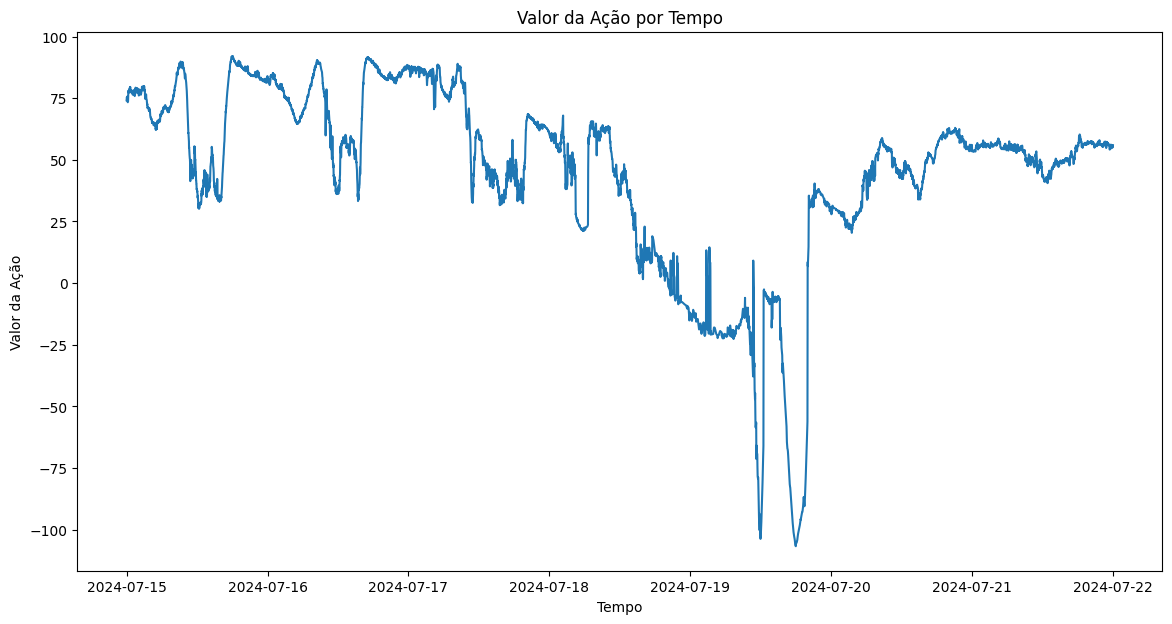

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index, actions_value, label='Valor da ação - Treinamento')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

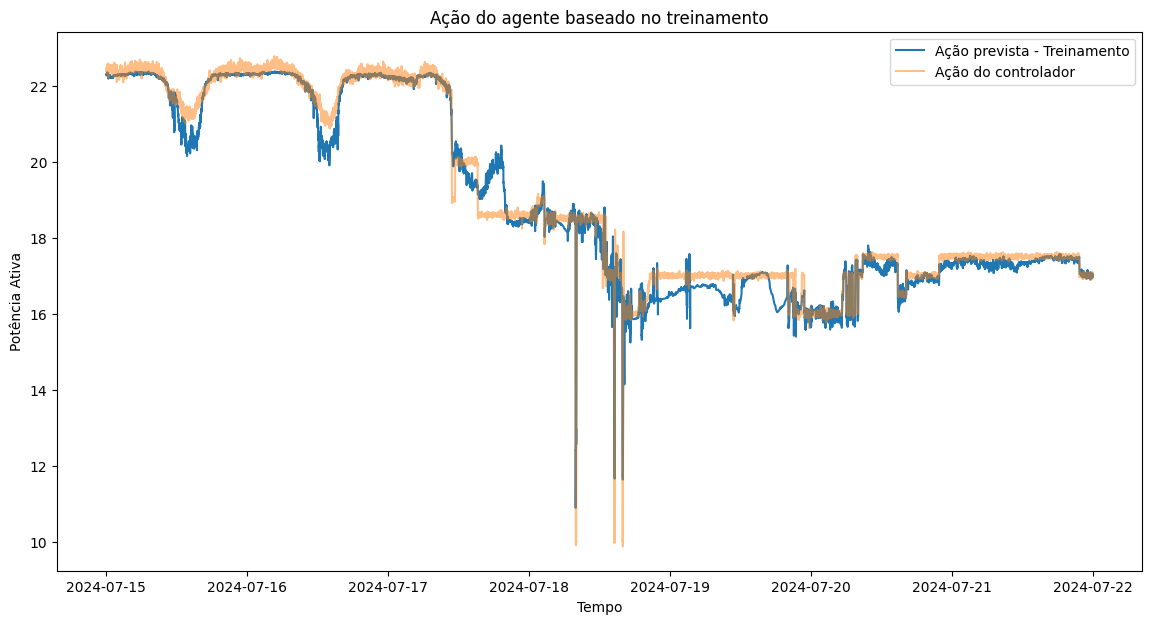

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index, predict_actions, label='Ação prevista - Treinamento')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
full_agent.save("/content/drive/MyDrive/Conf2/Full_Agent_100")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240928190245 /content/drive/MyDrive/Conf2/Full_agent_100%

### 85% de treino

In [ ]:
observations = df_final.values
actions = df_actions["POTENCIA_ATIVA_GERADOR"].values
rewards = df_reward.values
timeouts = np.zeros(len(rewards))
timeouts[1440::1440] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-2]
index = df_final.index
episodes

array([ 1440,  2880,  4320,  5760,  7200,  8640, 10080])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-25 18:19.45 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-25 18:19.45 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-25 18:19.45 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
full_agent = agent(CQLConfig)
full_agent.set_dataset(dataset)
n_steps_per_epoch = 10000
epochs = 5
full_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-25 18:19.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-25 18:19.51 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-25 18:19.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-25 18:19.51 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-25 18:19.51 [info     ] Directory is created at d3rlpy_logs/CQL_20240925181951
2024-09-25 18:19.51 [debug    ] Building models...            
2024-09-25 18:19.51 [debug    ] Models have been built.       
2024-09-25 18:19.51 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:24.38 [info     ] CQL_20240925181951: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0046967848062515255, 'time_algorithm_update': 0.023355192399024963, 'critic_loss': -56.60831956520081, 'conservative_loss': -57.21685299987793, 'alpha': 0.6417245072752237, 'actor_loss': -14.229726705235615, 'temp': 1.6976338393628598, 'temp_loss': -1.3001636251753197, 'time_step': 0.028416735410690307, 'td_error': 0.5588233308801659, 'ave_value': 32.25551952136757} step=10000
2024-09-25 18:24.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925181951/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:29.24 [info     ] CQL_20240925181951: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.004650935459136963, 'time_algorithm_update': 0.02326032214164734, 'critic_loss': -22.688753636169434, 'conservative_loss': -23.673084320640562, 'alpha': 0.25753486935943365, 'actor_loss': -31.41472140045166, 'temp': 4.665173592400551, 'temp_loss': -1.6152594802159816, 'time_step': 0.028263671040534972, 'td_error': 0.6232699013812747, 'ave_value': 45.334340188402486} step=20000
2024-09-25 18:29.24 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925181951/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:34.09 [info     ] CQL_20240925181951: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.004643111324310303, 'time_algorithm_update': 0.023205698084831236, 'critic_loss': -7.068576197719574, 'conservative_loss': -9.453120688199997, 'alpha': 0.1042384373575449, 'actor_loss': -31.724913875770568, 'temp': 7.8260506134033205, 'temp_loss': -0.0992940875025466, 'time_step': 0.02820772888660431, 'td_error': 1.9220394379696668, 'ave_value': 41.18697275085796} step=30000
2024-09-25 18:34.09 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925181951/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:38.55 [info     ] CQL_20240925181951: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.004667300343513489, 'time_algorithm_update': 0.02325652174949646, 'critic_loss': 0.4416499212026596, 'conservative_loss': -3.742936684346199, 'alpha': 0.04223054953366518, 'actor_loss': -27.59734961795807, 'temp': 7.449308417224884, 'temp_loss': 0.033203829195164146, 'time_step': 0.028288521337509157, 'td_error': 2.1594163633137753, 'ave_value': 37.6773213140481} step=40000
2024-09-25 18:38.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925181951/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:43.41 [info     ] CQL_20240925181951: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.004698944211006165, 'time_algorithm_update': 0.023298656702041627, 'critic_loss': 4.14910839278698, 'conservative_loss': -1.4838293173968793, 'alpha': 0.017110676088929175, 'actor_loss': -26.228447395706176, 'temp': 7.018475021028519, 'temp_loss': 0.02123380755390972, 'time_step': 0.028369918012619018, 'td_error': 3.0566026932148125, 'ave_value': 36.17614358006165} step=50000
2024-09-25 18:43.41 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925181951/model_50000.d3


In [ ]:
# actions predicted
predict_actions_train = full_agent.predict(observations_train)
predict_actions_test = full_agent.predict(observations_test)
# action values
actions_value_train = full_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = full_agent.predict_value(observations_test, predict_actions_test)

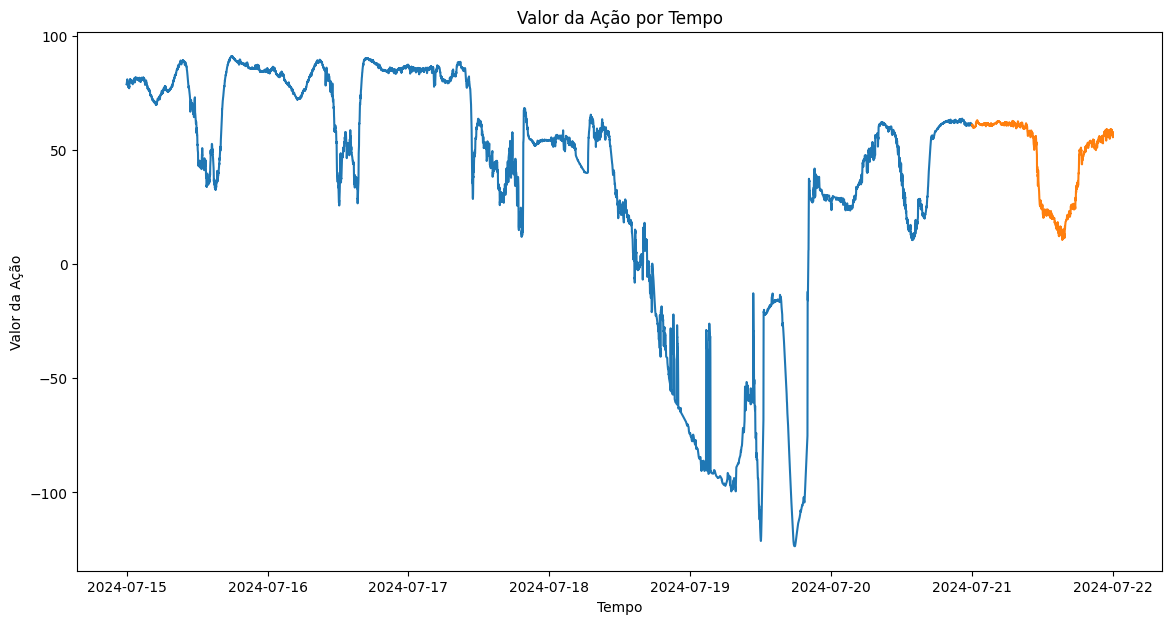

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

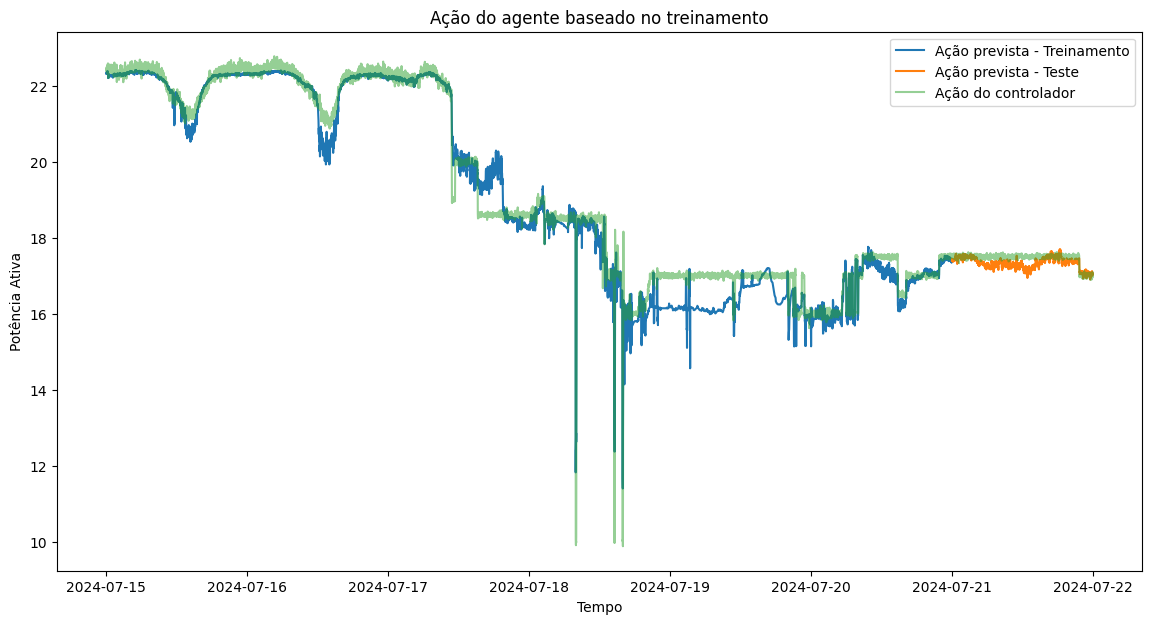

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
full_agent.save("/content/drive/MyDrive/Conf2/Full_Agent_85")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240925181951 /content/drive/MyDrive/Conf2/Full_agent_85%

### 70% de treino

In [ ]:
observations = df_final.values
actions = df_actions["POTENCIA_ATIVA_GERADOR"].values
rewards = df_reward.values
timeouts = np.zeros(len(rewards))
timeouts[1440::1440] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-3]
index = df_final.index
episodes

array([ 1440,  2880,  4320,  5760,  7200,  8640, 10080])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-25 18:53.08 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-25 18:53.08 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-25 18:53.08 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
full_agent = agent(CQLConfig)
full_agent.set_dataset(dataset)
n_steps_per_epoch = 10000
epochs = 5
full_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-25 17:12.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-25 17:12.45 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-25 17:12.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-25 17:12.45 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-25 17:12.45 [info     ] Directory is created at d3rlpy_logs/CQL_20240925171245
2024-09-25 17:12.45 [debug    ] Building models...            
2024-09-25 17:12.46 [debug    ] Models have been built.       
2024-09-25 17:12.47 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 17:17.41 [info     ] CQL_20240925171245: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.004761944341659546, 'time_algorithm_update': 0.023996638131141664, 'critic_loss': -57.01177389526367, 'conservative_loss': -57.633615641784665, 'alpha': 0.6415307870984077, 'actor_loss': -14.54528957335055, 'temp': 1.7098203696966172, 'temp_loss': -1.3986039340920746, 'time_step': 0.029114937257766725, 'td_error': 0.5339086202042249, 'ave_value': 32.80573888617532} step=10000
2024-09-25 17:17.41 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925171245/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 17:22.29 [info     ] CQL_20240925171245: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.00463968517780304, 'time_algorithm_update': 0.02355013542175293, 'critic_loss': -22.45534428782463, 'conservative_loss': -23.714053221321105, 'alpha': 0.25760193103700874, 'actor_loss': -31.20525723171234, 'temp': 4.7218378241539005, 'temp_loss': -1.8082004320673644, 'time_step': 0.02852638692855835, 'td_error': 0.9706765962582071, 'ave_value': 43.39730637790785} step=20000
2024-09-25 17:22.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925171245/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 17:27.22 [info     ] CQL_20240925171245: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0048293703317642215, 'time_algorithm_update': 0.023823674607276916, 'critic_loss': -4.275475262403488, 'conservative_loss': -9.48385477156639, 'alpha': 0.10425689781531691, 'actor_loss': -24.37152965078354, 'temp': 8.615671892786025, 'temp_loss': -0.2301185056621209, 'time_step': 0.029023237299919128, 'td_error': 4.090557338090293, 'ave_value': 30.161379320470367} step=30000
2024-09-25 17:27.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925171245/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 17:32.14 [info     ] CQL_20240925171245: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.004778374910354614, 'time_algorithm_update': 0.02371147665977478, 'critic_loss': 8.702842359805107, 'conservative_loss': -3.704592763185501, 'alpha': 0.042291730600781736, 'actor_loss': -12.266997611355782, 'temp': 8.624675816822052, 'temp_loss': 0.0352911368008703, 'time_step': 0.028857766008377077, 'td_error': 8.238236879368037, 'ave_value': 20.540616440886488} step=40000
2024-09-25 17:32.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925171245/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 17:37.06 [info     ] CQL_20240925171245: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.00480954134464264, 'time_algorithm_update': 0.02372497479915619, 'critic_loss': 20.16291638196707, 'conservative_loss': -1.4426388408243656, 'alpha': 0.017168454665411264, 'actor_loss': -7.330835419607163, 'temp': 8.0014831428051, 'temp_loss': 0.030390565055422484, 'time_step': 0.028904702615737916, 'td_error': 14.190614960662522, 'ave_value': 18.199250094004476} step=50000
2024-09-25 17:37.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925171245/model_50000.d3


In [ ]:
# actions predicted
predict_actions_train = full_agent.predict(observations_train)
predict_actions_test = full_agent.predict(observations_test)
# action values
actions_value_train = full_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = full_agent.predict_value(observations_test, predict_actions_test)

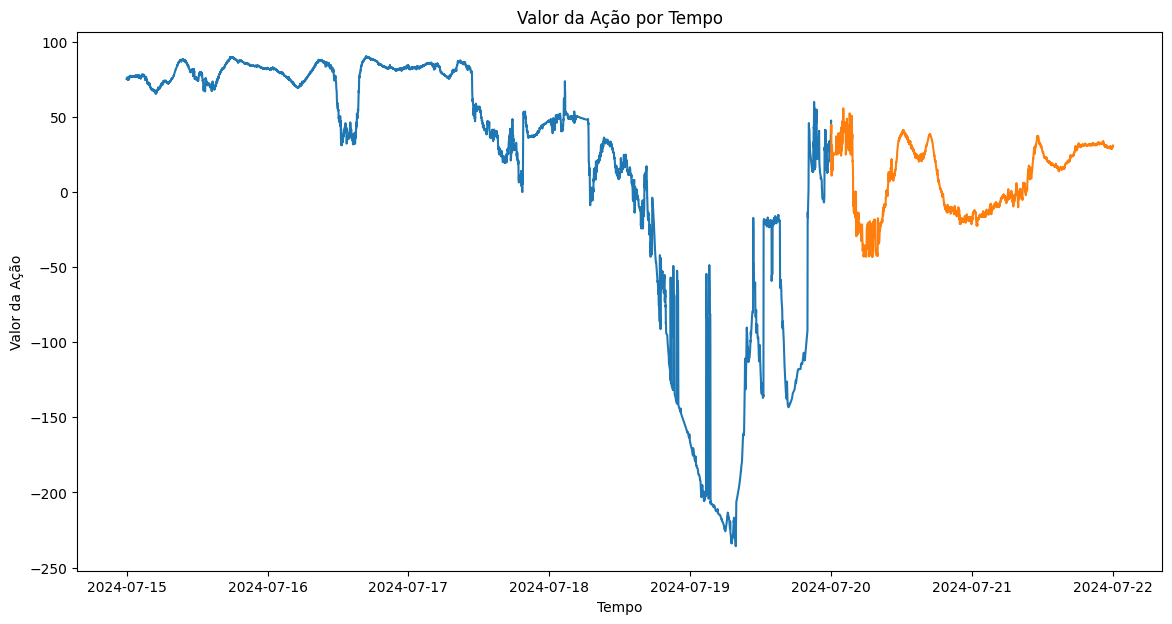

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

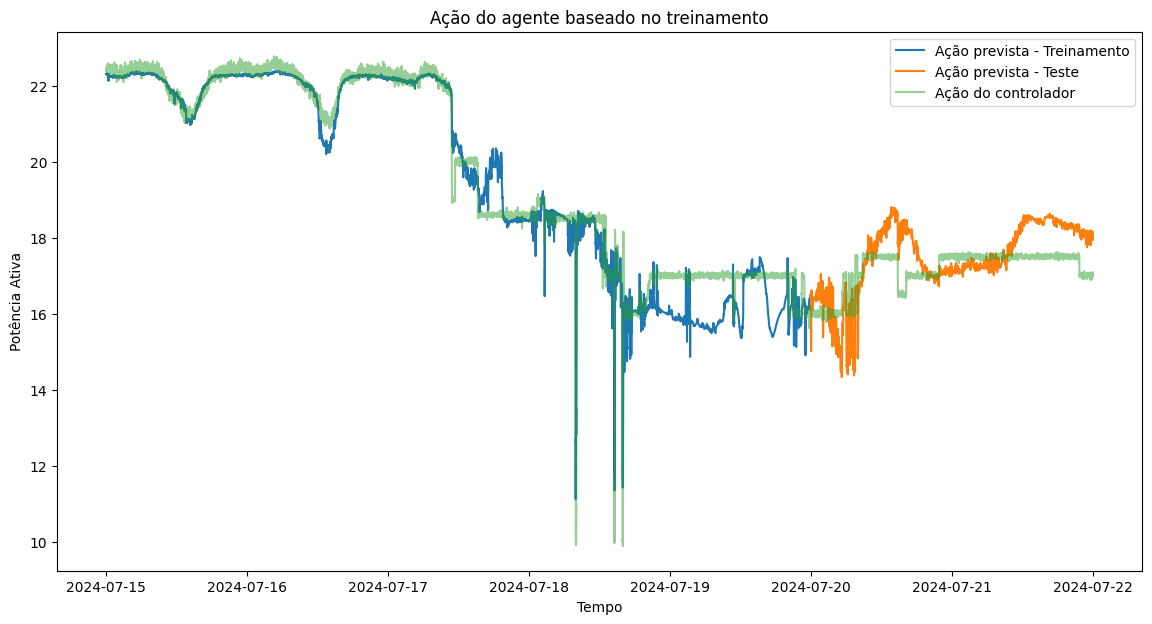

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
full_agent.save("/content/drive/MyDrive/Conf2/Full_Agent_70")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240925171245 /content/drive/MyDrive/Conf2/Full_agent_70%

### 57% de treino

In [ ]:
observations = df_final.values
actions = df_actions["POTENCIA_ATIVA_GERADOR"].values
rewards = df_reward.values
timeouts = np.zeros(len(rewards))
timeouts[1440::1440] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-4]
index = df_final.index
episodes

array([ 1440,  2880,  4320,  5760,  7200,  8640, 10080])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-25 17:51.13 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-25 17:51.13 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-25 17:51.13 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
full_agent = agent(CQLConfig)
full_agent.set_dataset(dataset)
n_steps_per_epoch = 10000
epochs = 5
full_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-25 17:51.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-25 17:51.19 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-25 17:51.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-25 17:51.19 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-25 17:51.19 [info     ] Directory is created at d3rlpy_logs/CQL_20240925175119
2024-09-25 17:51.19 [debug    ] Building models...            
2024-09-25 17:51.19 [debug    ] Models have been built.       
2024-09-25 17:51.19 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 17:56.07 [info     ] CQL_20240925175119: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.004665660643577576, 'time_algorithm_update': 0.023488284063339235, 'critic_loss': -56.20481776208877, 'conservative_loss': -56.92173623485565, 'alpha': 0.6425182816773654, 'actor_loss': -15.7805838298589, 'temp': 1.6924660730540753, 'temp_loss': -1.1823977858822792, 'time_step': 0.028513296675682066, 'td_error': 0.6296698189240121, 'ave_value': 35.34112168807877} step=10000
2024-09-25 17:56.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925175119/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:00.52 [info     ] CQL_20240925175119: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.00455298056602478, 'time_algorithm_update': 0.02332223587036133, 'critic_loss': -22.56246279888153, 'conservative_loss': -23.680425449371338, 'alpha': 0.2579115092352033, 'actor_loss': -35.768487859153744, 'temp': 4.743160162615776, 'temp_loss': -1.8828002607941627, 'time_step': 0.028217782521247865, 'td_error': 0.712480917921181, 'ave_value': 51.86112313235781} step=20000
2024-09-25 18:00.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925175119/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:05.39 [info     ] CQL_20240925175119: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.00461800947189331, 'time_algorithm_update': 0.023457920002937317, 'critic_loss': -7.801844269275665, 'conservative_loss': -9.525878654098511, 'alpha': 0.10430551384687424, 'actor_loss': -38.023881449127195, 'temp': 10.008705503559112, 'temp_loss': -0.5515932330735028, 'time_step': 0.02843354687690735, 'td_error': 0.9569726364687269, 'ave_value': 54.058097689617824} step=30000
2024-09-25 18:05.39 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925175119/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:10.29 [info     ] CQL_20240925175119: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.004736861228942871, 'time_algorithm_update': 0.023562801647186278, 'critic_loss': -1.5460913166999817, 'conservative_loss': -3.809851279783249, 'alpha': 0.04221138937994838, 'actor_loss': -35.64417204990387, 'temp': 11.897282921791076, 'temp_loss': -0.053393696965277196, 'time_step': 0.028670570397377013, 'td_error': 1.1742124832788632, 'ave_value': 53.25676862817579} step=40000
2024-09-25 18:10.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925175119/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 18:15.25 [info     ] CQL_20240925175119: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.004965592312812805, 'time_algorithm_update': 0.02394593894481659, 'critic_loss': 0.8998486868321895, 'conservative_loss': -1.522890170556307, 'alpha': 0.017085249593295156, 'actor_loss': -34.556598603057864, 'temp': 12.123983406352997, 'temp_loss': 0.01851637255474925, 'time_step': 0.029298623251914978, 'td_error': 1.3277450107763271, 'ave_value': 51.81756727824521} step=50000
2024-09-25 18:15.25 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925175119/model_50000.d3


In [ ]:
# actions predicted
predict_actions_train = full_agent.predict(observations_train)
predict_actions_test = full_agent.predict(observations_test)
# action values
actions_value_train = full_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = full_agent.predict_value(observations_test, predict_actions_test)

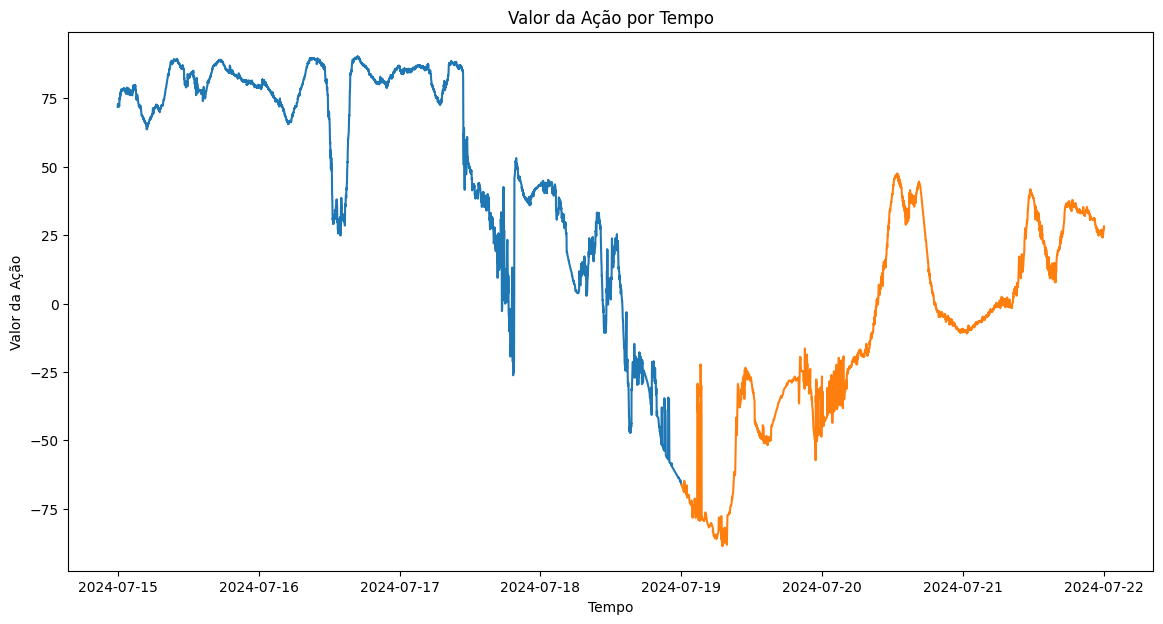

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

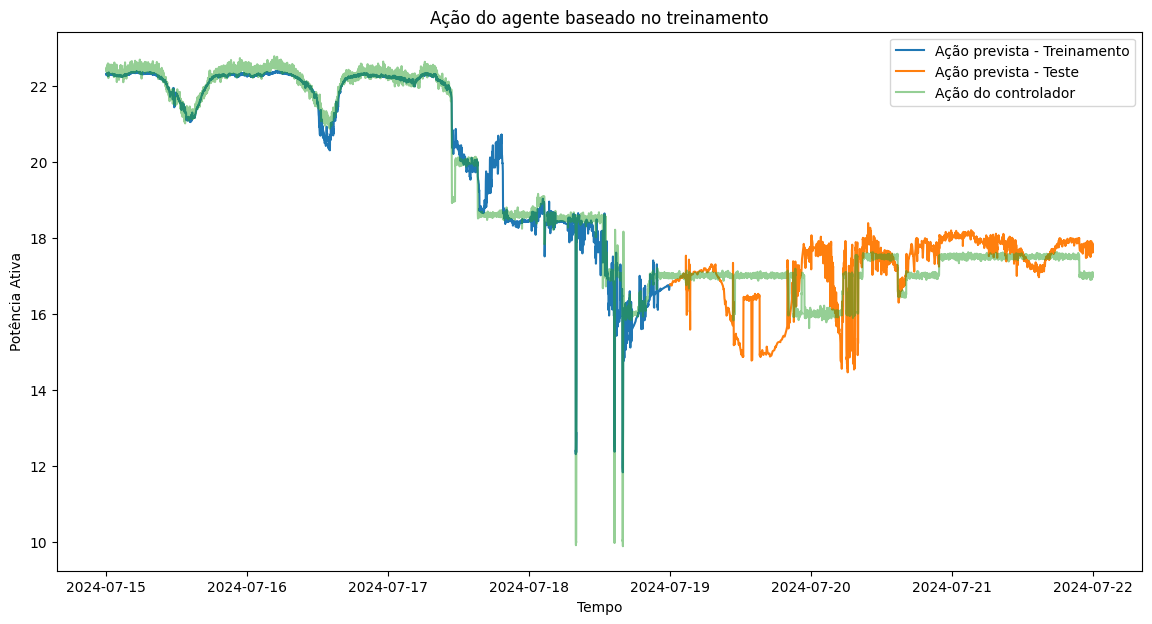

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador',alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
full_agent.save("/content/drive/MyDrive/Conf2/Full_Agent_57")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240925175119 /content/drive/MyDrive/Conf2/Full_agent_57%

### 42% de treino

In [ ]:
observations = df_final.values
actions = df_actions["POTENCIA_ATIVA_GERADOR"].values
rewards = df_reward.values
timeouts = np.zeros(len(rewards))
timeouts[1440::1440] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-5]
index = df_final.index
episodes

array([ 1440,  2880,  4320,  5760,  7200,  8640, 10080])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-25 18:57.35 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-25 18:57.35 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-25 18:57.35 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
full_agent = agent(CQLConfig)
full_agent.set_dataset(dataset)
n_steps_per_epoch = 10000
epochs = 5
full_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-25 18:57.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-25 18:57.40 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-25 18:57.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-25 18:57.40 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-25 18:57.40 [info     ] Directory is created at d3rlpy_logs/CQL_20240925185740
2024-09-25 18:57.40 [debug    ] Building models...            
2024-09-25 18:57.40 [debug    ] Models have been built.       
2024-09-25 18:57.40 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 19:02.28 [info     ] CQL_20240925185740: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.004704472494125366, 'time_algorithm_update': 0.02344945206642151, 'critic_loss': -52.61517671203613, 'conservative_loss': -53.2359591758728, 'alpha': 0.6437080665916205, 'actor_loss': -13.844365753902494, 'temp': 1.5654765198171139, 'temp_loss': -0.5170160503557883, 'time_step': 0.02853092200756073, 'td_error': 0.5420182482788258, 'ave_value': 29.619570751221104} step=10000
2024-09-25 19:02.28 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925185740/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 19:07.15 [info     ] CQL_20240925185740: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.004663456010818481, 'time_algorithm_update': 0.02337495982646942, 'critic_loss': -21.29731723012924, 'conservative_loss': -21.894184654998778, 'alpha': 0.2586112626761198, 'actor_loss': -30.990855579948427, 'temp': 4.027458367037773, 'temp_loss': -0.5095608410768211, 'time_step': 0.028400812244415284, 'td_error': 0.4201977401120601, 'ave_value': 43.12389873581257} step=20000
2024-09-25 19:07.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925185740/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 19:12.01 [info     ] CQL_20240925185740: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.004611924433708191, 'time_algorithm_update': 0.02326064395904541, 'critic_loss': -7.9789202404260635, 'conservative_loss': -8.778570797157288, 'alpha': 0.10462095083519816, 'actor_loss': -37.7107144443512, 'temp': 6.329217143249512, 'temp_loss': -0.07186590851265937, 'time_step': 0.028239002394676208, 'td_error': 0.6309888950911736, 'ave_value': 49.50404254421281} step=30000
2024-09-25 19:12.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925185740/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 19:16.46 [info     ] CQL_20240925185740: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.004625754570960998, 'time_algorithm_update': 0.023280503010749815, 'critic_loss': -2.6761793142437935, 'conservative_loss': -3.510436904168129, 'alpha': 0.04234717523679137, 'actor_loss': -42.52290089378357, 'temp': 6.823829471492767, 'temp_loss': -2.7163406647741793e-05, 'time_step': 0.028277593445777894, 'td_error': 0.6166622734729353, 'ave_value': 54.18977354163405} step=40000
2024-09-25 19:16.46 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925185740/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-25 19:21.31 [info     ] CQL_20240925185740: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.00462583954334259, 'time_algorithm_update': 0.02325103394985199, 'critic_loss': -0.5393461110204458, 'conservative_loss': -1.4049956626594067, 'alpha': 0.01713751700464636, 'actor_loss': -46.851202922439576, 'temp': 6.4672155303955075, 'temp_loss': 0.04031721829809248, 'time_step': 0.028245448422431946, 'td_error': 1.0484655743600881, 'ave_value': 57.528054365174754} step=50000
2024-09-25 19:21.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240925185740/model_50000.d3


In [ ]:
# actions predicted
predict_actions_train = full_agent.predict(observations_train)
predict_actions_test = full_agent.predict(observations_test)
# action values
actions_value_train = full_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = full_agent.predict_value(observations_test, predict_actions_test)

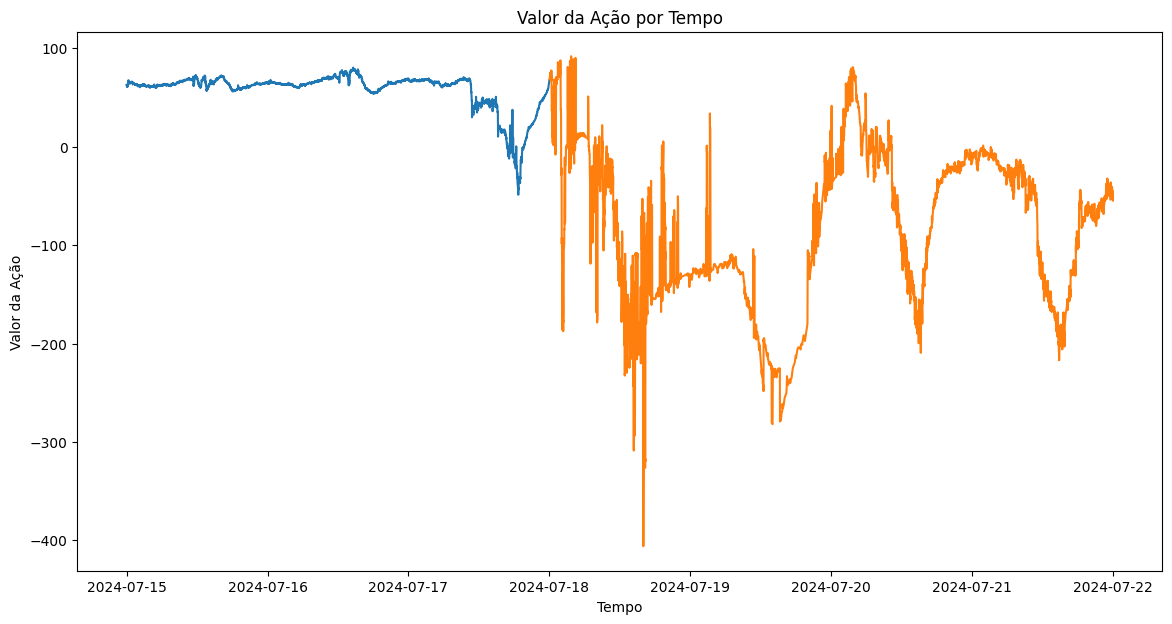

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

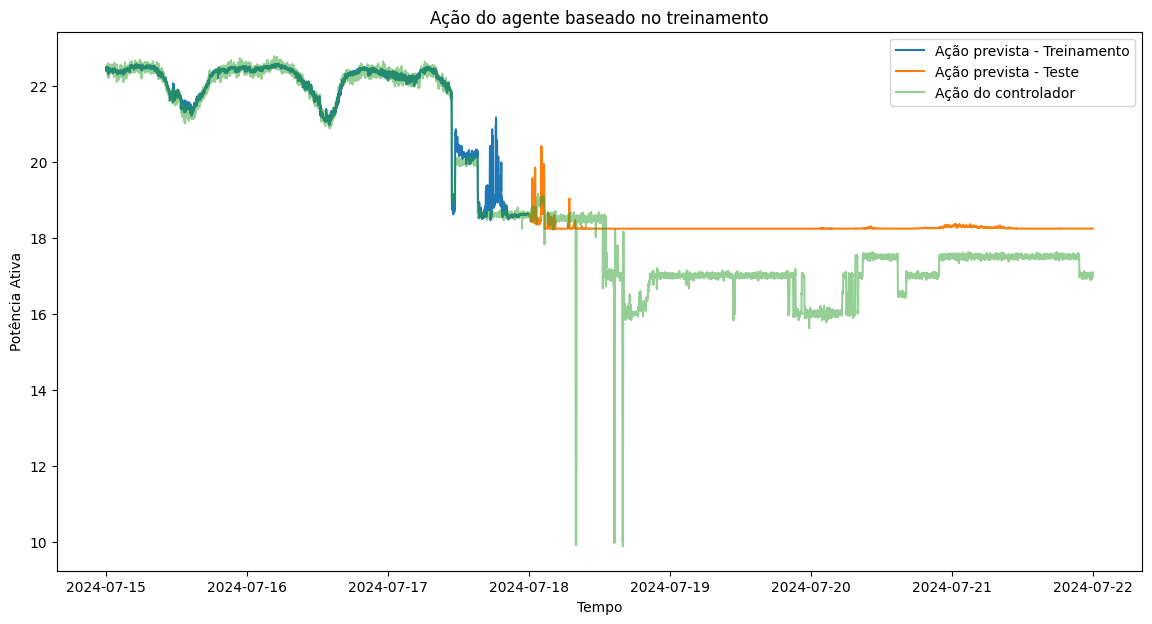

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador',alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
full_agent.save("/content/drive/MyDrive/Conf2/Full_Agent_42")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240925185740 /content/drive/MyDrive/Conf2/Full_agent_42%

## Agente da Região de H2 predominante

### 100% de treino

In [ ]:
observations_a = df_final.loc[:'2024-07-17 19:33:00'].values
observations_b = df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
observations_c = df_final.loc['2024-07-20 04:10:00':].values

observations = np.concatenate((observations_a, observations_b, observations_c))

actions_a = df_actions.loc[:'2024-07-17 19:33:00']["POTENCIA_ATIVA_GERADOR"].values
actions_b = df_actions.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00']["POTENCIA_ATIVA_GERADOR"].values
actions_c = df_actions.loc['2024-07-20 04:10:00':]["POTENCIA_ATIVA_GERADOR"].values
actions = np.concatenate((actions_a, actions_b, actions_c))

rewards_a = df_reward.loc[:'2024-07-17 19:33:00'].values
rewards_b = df_reward.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
rewards_c = df_reward.loc['2024-07-20 04:10:00':].values
rewards = np.concatenate((rewards_a, rewards_b, rewards_c))

timeouts = np.zeros(len(rewards))
timeouts[len(rewards_a)-1] = 1
timeouts[len(rewards_a) + len(rewards_b)-1] = 1
timeouts[1315] = 1
timeouts[2630] = 1
timeouts[5640] = 1
timeouts[-1] = 1

In [ ]:
index = df_final.loc[:'2024-07-17 19:33:00'].index.append(df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].index)
index = index.append(df_final.loc['2024-07-20 04:10:00':].index)

In [ ]:
dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=np.zeros(len(rewards)),
    timeouts=timeouts,
)

2024-09-27 21:53.46 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-27 21:53.46 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-27 21:53.46 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
hidro_agent = agent(CQLConfig)
hidro_agent.set_dataset(dataset)
n_steps_per_epoch = 6000
epochs = 5
hidro_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-27 21:53.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-27 21:53.48 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-27 21:53.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-27 21:53.49 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-27 21:53.49 [info     ] Directory is created at d3rlpy_logs/CQL_20240927215349
2024-09-27 21:53.49 [debug    ] Building models...            
2024-09-27 21:53.49 [debug    ] Models have been built.       
2024-09-27 21:53.49 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:56.44 [info     ] CQL_20240927215349: epoch=1 step=6000 epoch=1 metrics={'time_sample_batch': 0.004933888912200928, 'time_algorithm_update': 0.023650708635648093, 'critic_loss': -67.18111766751608, 'conservative_loss': -67.60022398058574, 'alpha': 0.7545186277925968, 'actor_loss': -9.200536489454718, 'temp': 1.3451900963882606, 'temp_loss': -1.2599864602186717, 'time_step': 0.028885768175125122, 'td_error': 0.7058688481485527, 'ave_value': 23.73163667854997} step=6000
2024-09-27 21:56.44 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927215349/model_6000.d3


Epoch 2/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:59.39 [info     ] CQL_20240927215349: epoch=2 step=12000 epoch=2 metrics={'time_sample_batch': 0.004913540720939636, 'time_algorithm_update': 0.023613351941108703, 'critic_loss': -40.4512160320282, 'conservative_loss': -41.05021433448791, 'alpha': 0.43341212488214176, 'actor_loss': -25.283614121119182, 'temp': 2.6052156628370287, 'temp_loss': -2.566795270740986, 'time_step': 0.028814266761144004, 'td_error': 0.5468064555396073, 'ave_value': 38.82980084038522} step=12000
2024-09-27 21:59.39 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927215349/model_12000.d3


Epoch 3/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 22:02.32 [info     ] CQL_20240927215349: epoch=3 step=18000 epoch=3 metrics={'time_sample_batch': 0.004894802014033, 'time_algorithm_update': 0.02340819803873698, 'critic_loss': -21.954204464276632, 'conservative_loss': -23.005320707524817, 'alpha': 0.25277499202887216, 'actor_loss': -34.150945821762086, 'temp': 4.530223879218101, 'temp_loss': -1.7272377915742496, 'time_step': 0.028587922890981037, 'td_error': 0.3708079530489872, 'ave_value': 47.94342321479017} step=18000
2024-09-27 22:02.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927215349/model_18000.d3


Epoch 4/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 22:05.31 [info     ] CQL_20240927215349: epoch=4 step=24000 epoch=4 metrics={'time_sample_batch': 0.005053381919860839, 'time_algorithm_update': 0.023935898621877033, 'critic_loss': -13.001996036609015, 'conservative_loss': -13.748893528143565, 'alpha': 0.14651490669324993, 'actor_loss': -36.54930274899801, 'temp': 8.137961977799733, 'temp_loss': -1.8590009607722362, 'time_step': 0.0292856125831604, 'td_error': 0.4021188627006559, 'ave_value': 53.323912986798724} step=24000
2024-09-27 22:05.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927215349/model_24000.d3


Epoch 5/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 22:08.29 [info     ] CQL_20240927215349: epoch=5 step=30000 epoch=5 metrics={'time_sample_batch': 0.005175254225730896, 'time_algorithm_update': 0.02398636519908905, 'critic_loss': -6.97749014266332, 'conservative_loss': -7.986347823858261, 'alpha': 0.08508074467629194, 'actor_loss': -33.944261459350585, 'temp': 12.518507252057393, 'temp_loss': -0.5800314993827294, 'time_step': 0.02946624998251597, 'td_error': 0.5094875472913275, 'ave_value': 54.046825372157485} step=30000
2024-09-27 22:08.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927215349/model_30000.d3


In [ ]:
predict_actions = hidro_agent.predict(observations)
actions_value = hidro_agent.predict_value(observations, predict_actions)

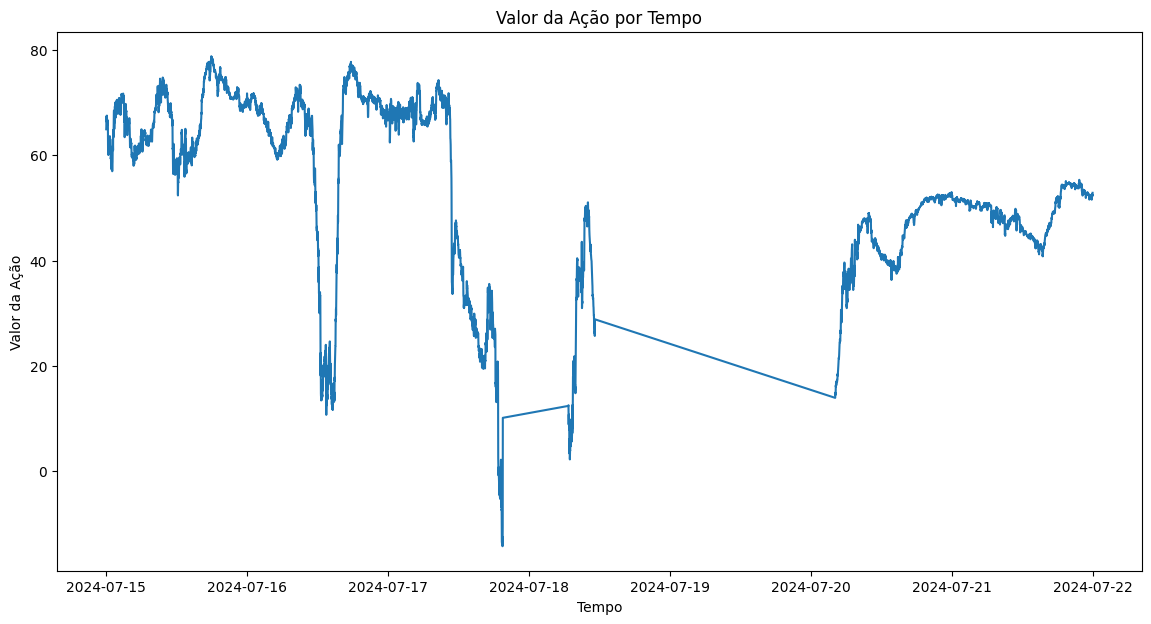

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index, actions_value, label='Valor da ação - Treinamento')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

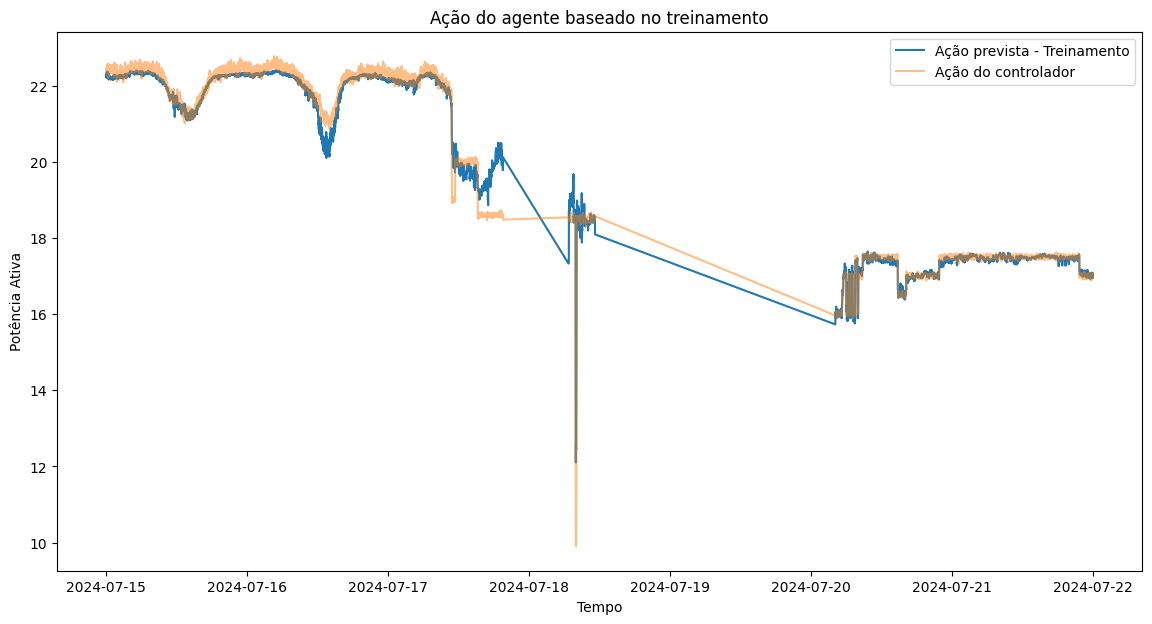

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index, predict_actions, label='Ação prevista - Treinamento')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
hidro_agent.save("/content/drive/MyDrive/Conf2/Hidrogenio_Agent_100")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240927215349 /content/drive/MyDrive/Conf2/Hidrogenio_agent_100%

### 80% de treino

In [ ]:
observations_a = df_final.loc[:'2024-07-17 19:33:00'].values
observations_b = df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
observations_c = df_final.loc['2024-07-20 04:10:00':].values

observations = np.concatenate((observations_a, observations_b, observations_c))

actions_a = df_actions.loc[:'2024-07-17 19:33:00']["POTENCIA_ATIVA_GERADOR"].values
actions_b = df_actions.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00']["POTENCIA_ATIVA_GERADOR"].values
actions_c = df_actions.loc['2024-07-20 04:10:00':]["POTENCIA_ATIVA_GERADOR"].values
actions = np.concatenate((actions_a, actions_b, actions_c))

rewards_a = df_reward.loc[:'2024-07-17 19:33:00'].values
rewards_b = df_reward.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
rewards_c = df_reward.loc['2024-07-20 04:10:00':].values
rewards = np.concatenate((rewards_a, rewards_b, rewards_c))

timeouts = np.zeros(len(rewards))
timeouts[len(rewards_a)-1] = 1
timeouts[len(rewards_a) + len(rewards_b)-1] = 1
timeouts[1315] = 1
timeouts[2630] = 1
timeouts[5640] = 1
timeouts[-1] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-2]
index = df_final.loc[:'2024-07-17 19:33:00'].index.append(df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].index)
index = index.append(df_final.loc['2024-07-20 04:10:00':].index)
episodes

array([1315, 2630, 4053, 4325, 5640, 6956])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-27 20:15.17 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-27 20:15.17 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-27 20:15.17 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
hidro_agent = agent(CQLConfig)
hidro_agent.set_dataset(dataset)
n_steps_per_epoch = 6000
epochs = 5
hidro_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-27 20:15.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-27 20:15.40 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-27 20:15.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-27 20:15.40 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-27 20:15.40 [info     ] Directory is created at d3rlpy_logs/CQL_20240927201540
2024-09-27 20:15.40 [debug    ] Building models...            
2024-09-27 20:15.40 [debug    ] Models have been built.       
2024-09-27 20:15.40 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:18.49 [info     ] CQL_20240927201540: epoch=1 step=6000 epoch=1 metrics={'time_sample_batch': 0.0052979615926742555, 'time_algorithm_update': 0.025358567158381144, 'critic_loss': -66.702716255188, 'conservative_loss': -67.15347829182943, 'alpha': 0.7546435945232709, 'actor_loss': -9.093326207458974, 'temp': 1.3449511834979058, 'temp_loss': -1.1989063853148836, 'time_step': 0.030952688574790953, 'td_error': 0.7100564443189541, 'ave_value': 22.80122354150749} step=6000
2024-09-27 20:18.49 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927201540/model_6000.d3


Epoch 2/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:21.49 [info     ] CQL_20240927201540: epoch=2 step=12000 epoch=2 metrics={'time_sample_batch': 0.005047204693158468, 'time_algorithm_update': 0.024368932406107584, 'critic_loss': -38.97214313538869, 'conservative_loss': -39.8063020072331, 'alpha': 0.4344945315917333, 'actor_loss': -25.594114087104796, 'temp': 2.545746630827586, 'temp_loss': -1.8821738283963254, 'time_step': 0.029688011209170025, 'td_error': 0.49400208452245664, 'ave_value': 38.47214861411926} step=12000
2024-09-27 20:21.49 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927201540/model_12000.d3


Epoch 3/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:24.40 [info     ] CQL_20240927201540: epoch=3 step=18000 epoch=3 metrics={'time_sample_batch': 0.0047175910075505575, 'time_algorithm_update': 0.023146766503651935, 'critic_loss': -22.749804739952086, 'conservative_loss': -23.411556789398194, 'alpha': 0.25300960718343657, 'actor_loss': -35.17647683842977, 'temp': 4.527506501754125, 'temp_loss': -1.83958302055796, 'time_step': 0.02812271817525228, 'td_error': 0.3556110387815602, 'ave_value': 48.5438334200719} step=18000
2024-09-27 20:24.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927201540/model_18000.d3


Epoch 4/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:27.29 [info     ] CQL_20240927201540: epoch=4 step=24000 epoch=4 metrics={'time_sample_batch': 0.004686351140340169, 'time_algorithm_update': 0.022972002824147544, 'critic_loss': -12.86780530110995, 'conservative_loss': -13.64013026269277, 'alpha': 0.14683447951078415, 'actor_loss': -37.30343694432577, 'temp': 8.06023552163442, 'temp_loss': -1.5744763369796178, 'time_step': 0.027909881909688315, 'td_error': 0.4083151328318602, 'ave_value': 53.31274763172171} step=24000
2024-09-27 20:27.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927201540/model_24000.d3


Epoch 5/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:30.20 [info     ] CQL_20240927201540: epoch=5 step=30000 epoch=5 metrics={'time_sample_batch': 0.0047902340094248454, 'time_algorithm_update': 0.023144636114438375, 'critic_loss': -6.931796364625295, 'conservative_loss': -7.904845580736796, 'alpha': 0.085282141978542, 'actor_loss': -35.25819385751088, 'temp': 11.995055761814118, 'temp_loss': -0.4397882523785035, 'time_step': 0.028204946398735047, 'td_error': 0.5498396256396827, 'ave_value': 54.098293323479616} step=30000
2024-09-27 20:30.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927201540/model_30000.d3


In [ ]:
# actions predicted
predict_actions_train = hidro_agent.predict(observations_train)
predict_actions_test = hidro_agent.predict(observations_test)
# action values
actions_value_train = hidro_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = hidro_agent.predict_value(observations_test, predict_actions_test)

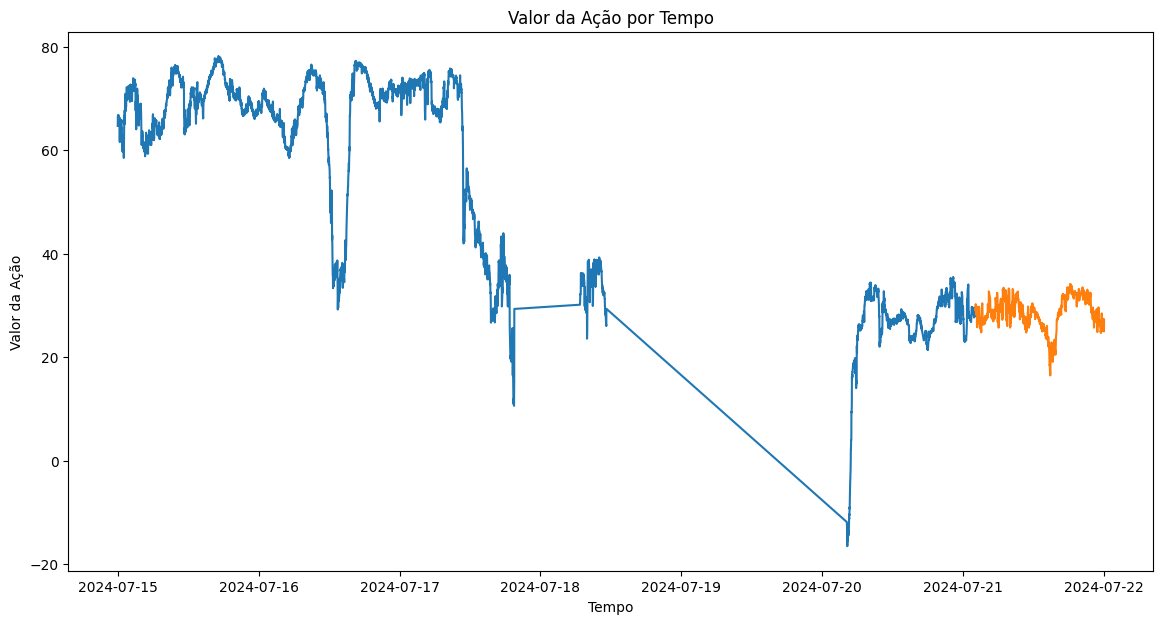

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

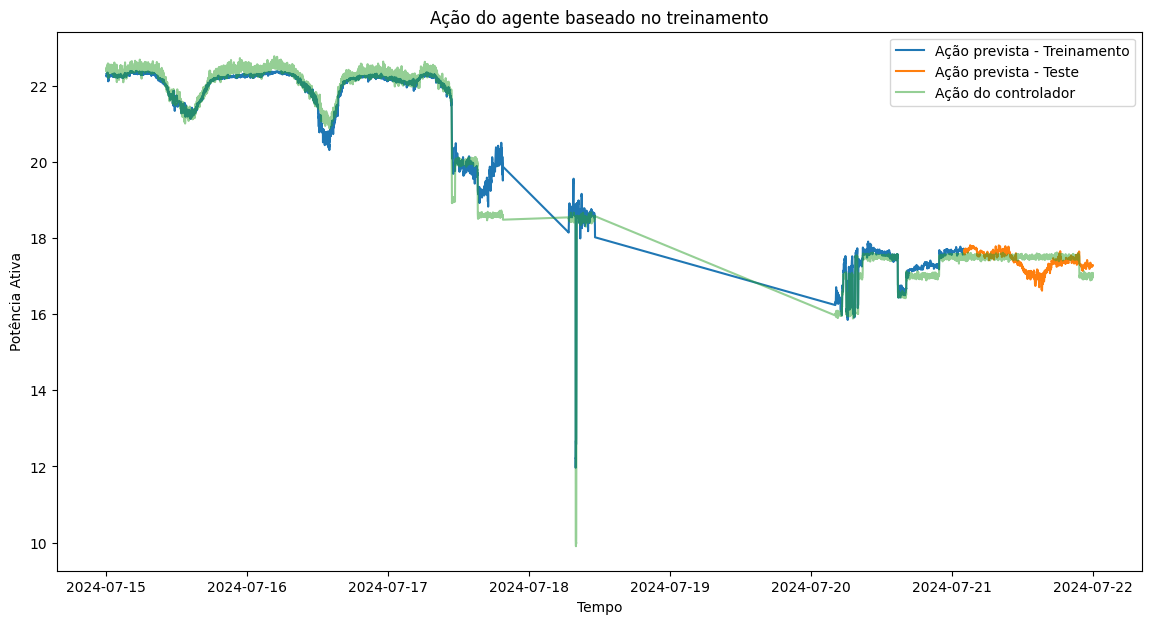

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
hidro_agent.save("/content/drive/MyDrive/Conf2/Hidrogenio_Agent_80")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240927201540 /content/drive/MyDrive/Conf2/Hidrogenio_agent_80%

### 62% de treino

In [ ]:
observations_a = df_final.loc[:'2024-07-17 19:33:00'].values
observations_b = df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
observations_c = df_final.loc['2024-07-20 04:10:00':].values

observations = np.concatenate((observations_a, observations_b, observations_c))

actions_a = df_actions.loc[:'2024-07-17 19:33:00']["POTENCIA_ATIVA_GERADOR"].values
actions_b = df_actions.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00']["POTENCIA_ATIVA_GERADOR"].values
actions_c = df_actions.loc['2024-07-20 04:10:00':]["POTENCIA_ATIVA_GERADOR"].values
actions = np.concatenate((actions_a, actions_b, actions_c))

rewards_a = df_reward.loc[:'2024-07-17 19:33:00'].values
rewards_b = df_reward.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
rewards_c = df_reward.loc['2024-07-20 04:10:00':].values
rewards = np.concatenate((rewards_a, rewards_b, rewards_c))

timeouts = np.zeros(len(rewards))
timeouts[len(rewards_a)-1] = 1
timeouts[len(rewards_a) + len(rewards_b)-1] = 1
timeouts[1315] = 1
timeouts[2630] = 1
timeouts[5640] = 1
timeouts[-1] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-3]
index = df_final.loc[:'2024-07-17 19:33:00'].index.append(df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].index)
index = index.append(df_final.loc['2024-07-20 04:10:00':].index)
episodes

array([1315, 2630, 4053, 4325, 5640, 6956])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-27 20:32.53 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-27 20:32.53 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-27 20:32.53 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
hidro_agent = agent(CQLConfig)
hidro_agent.set_dataset(dataset)
n_steps_per_epoch = 6000
epochs = 5
hidro_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-27 20:32.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-27 20:32.56 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-27 20:32.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-27 20:32.56 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-27 20:32.56 [info     ] Directory is created at d3rlpy_logs/CQL_20240927203256
2024-09-27 20:32.56 [debug    ] Building models...            
2024-09-27 20:32.56 [debug    ] Models have been built.       
2024-09-27 20:32.56 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:35.54 [info     ] CQL_20240927203256: epoch=1 step=6000 epoch=1 metrics={'time_sample_batch': 0.005031662066777547, 'time_algorithm_update': 0.02390841813882192, 'critic_loss': -67.22952450370789, 'conservative_loss': -67.69913381640116, 'alpha': 0.7549542200863362, 'actor_loss': -9.498167046452561, 'temp': 1.3676474955578646, 'temp_loss': -1.3342042754205565, 'time_step': 0.02923864758014679, 'td_error': 0.8134199481682634, 'ave_value': 24.18173217743787} step=6000
2024-09-27 20:35.54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927203256/model_6000.d3


Epoch 2/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:38.46 [info     ] CQL_20240927203256: epoch=2 step=12000 epoch=2 metrics={'time_sample_batch': 0.004834586064020792, 'time_algorithm_update': 0.023223129550615947, 'critic_loss': -40.33626728916168, 'conservative_loss': -40.954551387468975, 'alpha': 0.433699781909585, 'actor_loss': -26.75852910073598, 'temp': 2.662348722239335, 'temp_loss': -2.771243200858434, 'time_step': 0.02831740208466848, 'td_error': 0.46523348408849985, 'ave_value': 41.76087899806046} step=12000
2024-09-27 20:38.46 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927203256/model_12000.d3


Epoch 3/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:41.41 [info     ] CQL_20240927203256: epoch=3 step=18000 epoch=3 metrics={'time_sample_batch': 0.005032800594965617, 'time_algorithm_update': 0.023544527967770894, 'critic_loss': -23.15434447002411, 'conservative_loss': -23.78474780337016, 'alpha': 0.2517963301762938, 'actor_loss': -37.07591582361857, 'temp': 5.014491797685623, 'temp_loss': -3.8911118041276933, 'time_step': 0.028850011348724364, 'td_error': 0.4574515772698934, 'ave_value': 53.98235682214316} step=18000
2024-09-27 20:41.41 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927203256/model_18000.d3


Epoch 4/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:44.33 [info     ] CQL_20240927203256: epoch=4 step=24000 epoch=4 metrics={'time_sample_batch': 0.004860351403554281, 'time_algorithm_update': 0.023318691849708556, 'critic_loss': -12.795306892792384, 'conservative_loss': -13.730444621245066, 'alpha': 0.14630583291873336, 'actor_loss': -39.401848998387656, 'temp': 9.258995867888133, 'temp_loss': -4.482341853280862, 'time_step': 0.028454158504803977, 'td_error': 0.6881569922612308, 'ave_value': 59.805614032992494} step=24000
2024-09-27 20:44.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927203256/model_24000.d3


Epoch 5/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 20:47.25 [info     ] CQL_20240927203256: epoch=5 step=30000 epoch=5 metrics={'time_sample_batch': 0.004829241553942362, 'time_algorithm_update': 0.02325404194990794, 'critic_loss': -6.065850442528725, 'conservative_loss': -7.886130953788757, 'alpha': 0.08506253870824973, 'actor_loss': -32.34481703186035, 'temp': 16.29461914475759, 'temp_loss': -3.363539114152392, 'time_step': 0.028354423681894936, 'td_error': 1.214415096582528, 'ave_value': 57.937870621726034} step=30000
2024-09-27 20:47.25 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927203256/model_30000.d3


In [ ]:
# actions predicted
predict_actions_train = hidro_agent.predict(observations_train)
predict_actions_test = hidro_agent.predict(observations_test)
# action values
actions_value_train = hidro_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = hidro_agent.predict_value(observations_test, predict_actions_test)

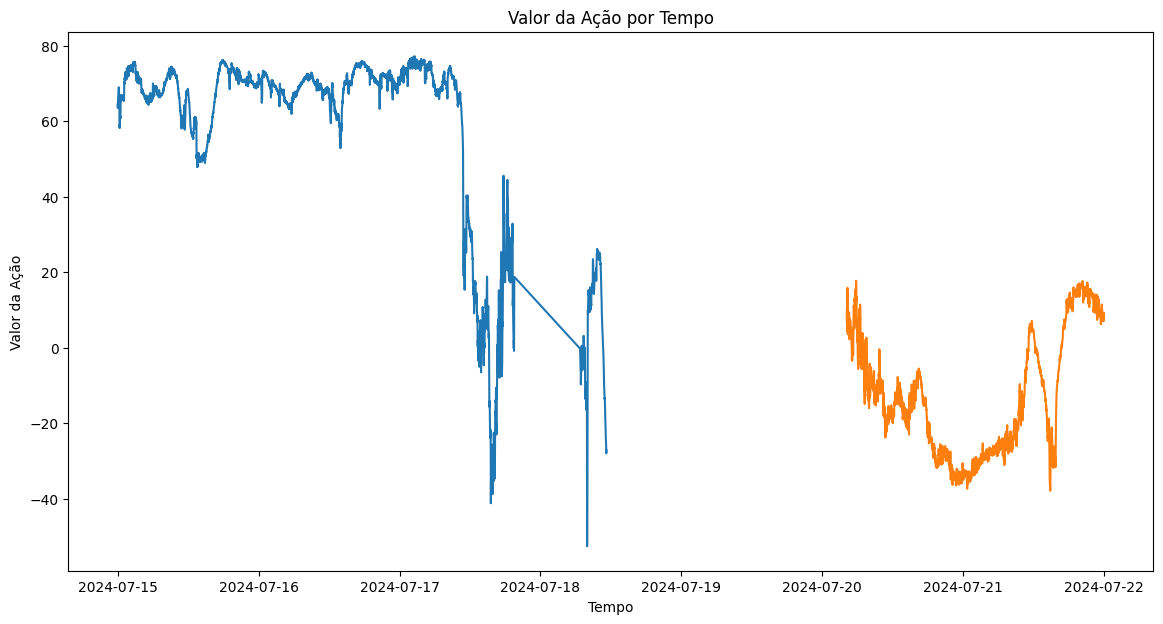

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

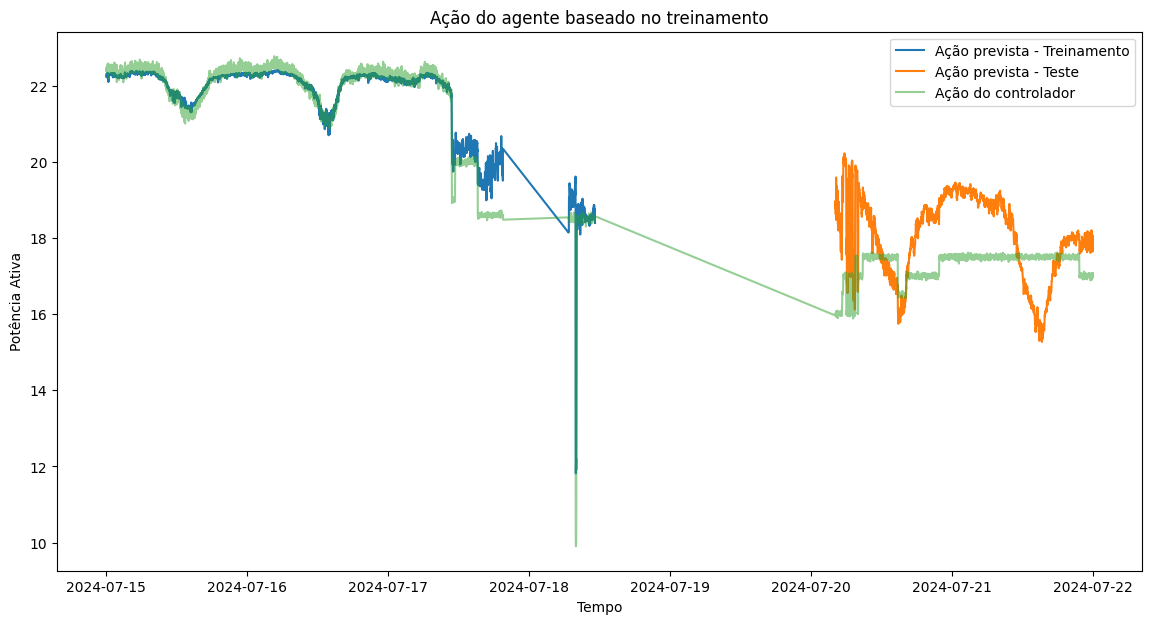

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
hidro_agent.save("/content/drive/MyDrive/Conf2/Hidrogenio_Agent_62")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240927203256 /content/drive/MyDrive/Conf2/Hidrogenio_agent_62%

## Agente da Região de Metano predominante

### 100% de treino

In [ ]:
observations_a = df_final.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].values
observations_b = df_final.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].values
observations = np.concatenate((observations_a, observations_b))

actions_a = df_actions.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00']["POTENCIA_ATIVA_GERADOR"].values
actions_b = df_actions.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00']["POTENCIA_ATIVA_GERADOR"].values
actions = np.concatenate((actions_a, actions_b))

rewards_a = df_reward.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].values
rewards_b = df_reward.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].values
rewards = np.concatenate((rewards_a, rewards_b))

timeouts = np.zeros(len(rewards))
timeouts[len(rewards_a)-1] = 1
timeouts[len(rewards_a) + len(rewards_b) // 2] = 1
timeouts[-1] = 1

In [ ]:
index = df_final.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].index.append(df_final.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].index)

In [ ]:
dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=np.zeros(len(rewards)),
    timeouts=timeouts,
)

2024-09-27 21:37.23 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-27 21:37.23 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-27 21:37.23 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
metan_agent = agent(CQLConfig)
metan_agent.set_dataset(dataset)
n_steps_per_epoch = 6000
epochs = 5
metan_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-27 21:37.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-27 21:37.34 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-27 21:37.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-27 21:37.34 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-27 21:37.34 [info     ] Directory is created at d3rlpy_logs/CQL_20240927213734
2024-09-27 21:37.34 [debug    ] Building models...            
2024-09-27 21:37.34 [debug    ] Models have been built.       
2024-09-27 21:37.34 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:41.19 [info     ] CQL_20240927213734: epoch=1 step=6000 epoch=1 metrics={'time_sample_batch': 0.006555751005808512, 'time_algorithm_update': 0.02995569916566213, 'critic_loss': -66.61418158658346, 'conservative_loss': -67.20084500249227, 'alpha': 0.7539361557463805, 'actor_loss': -7.049747711357816, 'temp': 1.324343478957812, 'temp_loss': -1.0743319050675102, 'time_step': 0.03690037755171458, 'td_error': 0.7489089972160573, 'ave_value': 19.02667852856636} step=6000
2024-09-27 21:41.19 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927213734/model_6000.d3


Epoch 2/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:44.11 [info     ] CQL_20240927213734: epoch=2 step=12000 epoch=2 metrics={'time_sample_batch': 0.004762175997098287, 'time_algorithm_update': 0.02332011576493581, 'critic_loss': -39.9378739083608, 'conservative_loss': -40.81137244033813, 'alpha': 0.43298552978535493, 'actor_loss': -19.225729122638704, 'temp': 2.5513714618086816, 'temp_loss': -2.12505218933026, 'time_step': 0.028357268611590068, 'td_error': 0.61478056350581, 'ave_value': 31.11670194892883} step=12000
2024-09-27 21:44.11 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927213734/model_12000.d3


Epoch 3/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:47.07 [info     ] CQL_20240927213734: epoch=3 step=18000 epoch=3 metrics={'time_sample_batch': 0.004967980583508809, 'time_algorithm_update': 0.023749228556950885, 'critic_loss': -22.368208802382153, 'conservative_loss': -23.751697950998942, 'alpha': 0.2512908959835768, 'actor_loss': -24.51297737058004, 'temp': 4.743550410270691, 'temp_loss': -2.562507420559724, 'time_step': 0.02900071720282237, 'td_error': 0.8816422176505101, 'ave_value': 37.288242302405834} step=18000
2024-09-27 21:47.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927213734/model_18000.d3


Epoch 4/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:50.00 [info     ] CQL_20240927213734: epoch=4 step=24000 epoch=4 metrics={'time_sample_batch': 0.004783279418945312, 'time_algorithm_update': 0.023398619333902995, 'critic_loss': -11.568695439894993, 'conservative_loss': -13.709062081972759, 'alpha': 0.14601426974808177, 'actor_loss': -23.67519821580251, 'temp': 8.322109340111414, 'temp_loss': -1.7628011740520597, 'time_step': 0.028454923033714295, 'td_error': 1.242075827147119, 'ave_value': 39.2822064716816} step=24000
2024-09-27 21:50.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927213734/model_24000.d3


Epoch 5/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 21:52.53 [info     ] CQL_20240927213734: epoch=5 step=30000 epoch=5 metrics={'time_sample_batch': 0.004823860685030619, 'time_algorithm_update': 0.023475462317466736, 'critic_loss': -4.8527969778378806, 'conservative_loss': -7.868893006722132, 'alpha': 0.08489912173276146, 'actor_loss': -21.00786561203003, 'temp': 11.533194934050242, 'temp_loss': -0.22292135564486185, 'time_step': 0.028603124062220254, 'td_error': 1.7293585622332228, 'ave_value': 39.64638758313656} step=30000
2024-09-27 21:52.53 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927213734/model_30000.d3


In [ ]:
predict_actions = metan_agent.predict(observations)
actions_value = metan_agent.predict_value(observations, predict_actions)

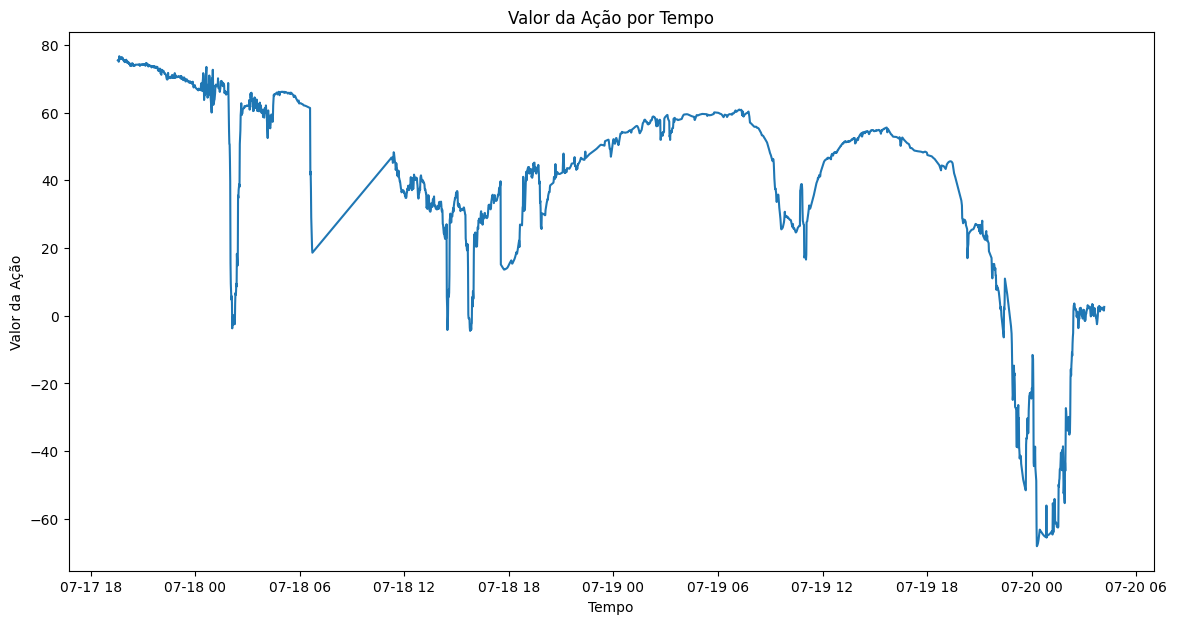

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index, actions_value, label='Valor da ação - Treinamento')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

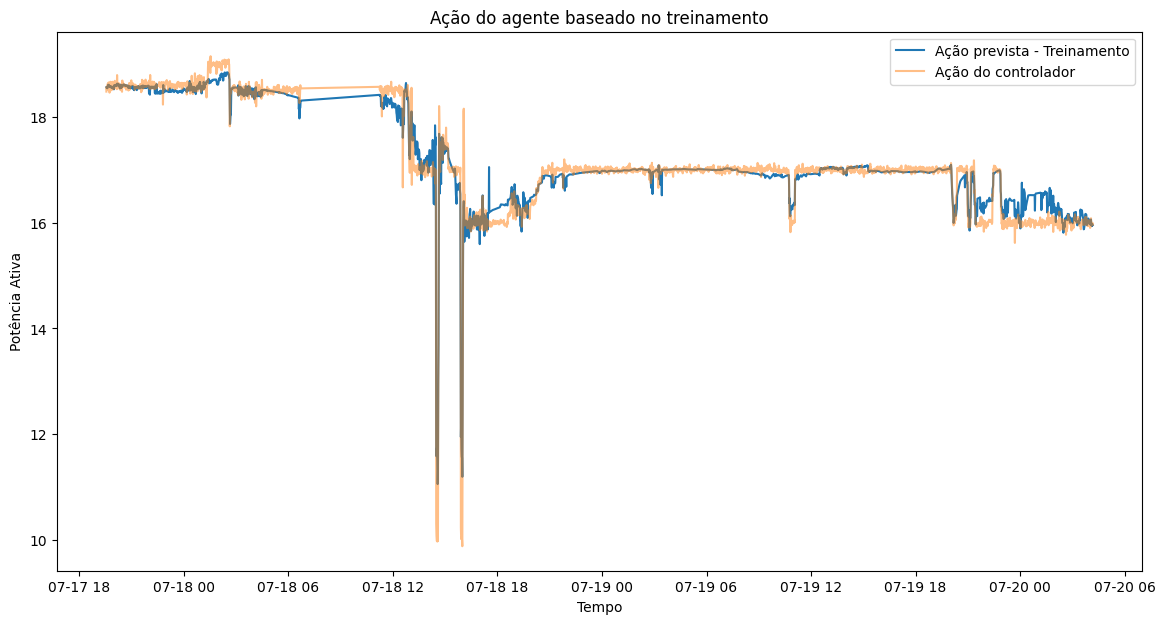

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index, predict_actions, label='Ação prevista - Treinamento')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
metan_agent.save("/content/drive/MyDrive/Conf2/Metano_Agent_100")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240927213734 /content/drive/MyDrive/Conf2/Metano_agent_100%

### 60% de treino

In [ ]:
observations_a = df_final.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].values
observations_b = df_final.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].values
observations = np.concatenate((observations_a, observations_b))

actions_a = df_actions.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00']["POTENCIA_ATIVA_GERADOR"].values
actions_b = df_actions.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00']["POTENCIA_ATIVA_GERADOR"].values
actions = np.concatenate((actions_a, actions_b))

rewards_a = df_reward.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].values
rewards_b = df_reward.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].values
rewards = np.concatenate((rewards_a, rewards_b))

timeouts = np.zeros(len(rewards))
timeouts[len(rewards_a)-1] = 1
timeouts[len(rewards_a) + len(rewards_b) // 2] = 1
timeouts[-1] = 1

In [ ]:
episodes = np.where(timeouts == 1)[0]
split = episodes[-2]
index = df_final.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].index.append(df_final.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].index)
episodes

array([ 670, 1899, 3127])

In [ ]:
observations_train, observations_test = split_timeseries(observations, split)
actions_train, actions_test = split_timeseries(actions, split)
rewards_train, _ = split_timeseries(rewards, split)
timeouts_train, _ = split_timeseries(timeouts, split)

In [ ]:
dataset = MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=np.zeros(len(rewards_train)),
    timeouts=timeouts_train,
)

2024-09-27 19:25.13 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-09-27 19:25.13 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2024-09-27 19:25.13 [info     ] Action size has been automatically determined. action_size=1


In [ ]:
metan_agent = agent(CQLConfig)
metan_agent.set_dataset(dataset)
n_steps_per_epoch = 6000
epochs = 5
metan_agent.fitting(n_steps=epochs*n_steps_per_epoch, n_steps_per_epoch=n_steps_per_epoch)

2024-09-27 19:25.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(8,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2024-09-27 19:25.46 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-09-27 19:25.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-27 19:25.46 [debug    ] Fitting reward scaler...       reward_scaler=min_max
2024-09-27 19:25.46 [info     ] Directory is created at d3rlpy_logs/CQL_20240927192546
2024-09-27 19:25.46 [debug    ] Building models...            
2024-09-27 19:25.48 [debug    ] Models have been built.       
2024-09-27 19:25.48 [info     ] Parameters                     params={'observation_shape': [8], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batch_size': 256, '

Epoch 1/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 19:28.55 [info     ] CQL_20240927192546: epoch=1 step=6000 epoch=1 metrics={'time_sample_batch': 0.00521929669380188, 'time_algorithm_update': 0.025329123854637144, 'critic_loss': -67.19400037066141, 'conservative_loss': -67.77584813372295, 'alpha': 0.7535609143674373, 'actor_loss': -7.73586176609993, 'temp': 1.3308293628593286, 'temp_loss': -1.1867655516249749, 'time_step': 0.030833295543988545, 'td_error': 0.8241398800426677, 'ave_value': 20.798634778555126} step=6000
2024-09-27 19:28.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927192546/model_6000.d3


Epoch 2/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 19:32.00 [info     ] CQL_20240927192546: epoch=2 step=12000 epoch=2 metrics={'time_sample_batch': 0.005200494925181071, 'time_algorithm_update': 0.02501330610116323, 'critic_loss': -40.371171629587806, 'conservative_loss': -41.12523396841685, 'alpha': 0.4327293431957563, 'actor_loss': -21.89971811644236, 'temp': 2.5688034984866777, 'temp_loss': -2.3458106597264607, 'time_step': 0.030499565601348876, 'td_error': 0.5571169478228697, 'ave_value': 34.98745720324011} step=12000
2024-09-27 19:32.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927192546/model_12000.d3


Epoch 3/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 19:34.59 [info     ] CQL_20240927192546: epoch=3 step=18000 epoch=3 metrics={'time_sample_batch': 0.005042243321736654, 'time_algorithm_update': 0.024108899593353272, 'critic_loss': -23.135614877065024, 'conservative_loss': -23.94799563376109, 'alpha': 0.25115221947679917, 'actor_loss': -29.173001928011576, 'temp': 4.77989748064677, 'temp_loss': -2.8624322458108264, 'time_step': 0.029418228626251222, 'td_error': 0.4996171511077139, 'ave_value': 43.736002336563374} step=18000
2024-09-27 19:34.59 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927192546/model_18000.d3


Epoch 4/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 19:37.52 [info     ] CQL_20240927192546: epoch=4 step=24000 epoch=4 metrics={'time_sample_batch': 0.004869890888532003, 'time_algorithm_update': 0.02346182111899058, 'critic_loss': -12.747485316197077, 'conservative_loss': -13.856937179724376, 'alpha': 0.145895799908787, 'actor_loss': -30.343125377019245, 'temp': 8.49852102859815, 'temp_loss': -2.2317712535696725, 'time_step': 0.028592193722724913, 'td_error': 0.7121383404926734, 'ave_value': 48.092608797757464} step=24000
2024-09-27 19:37.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927192546/model_24000.d3


Epoch 5/5:   0%|          | 0/6000 [00:00<?, ?it/s]

2024-09-27 19:40.59 [info     ] CQL_20240927192546: epoch=5 step=30000 epoch=5 metrics={'time_sample_batch': 0.005312586386998494, 'time_algorithm_update': 0.025237223426500956, 'critic_loss': -5.695581136584282, 'conservative_loss': -7.943090583403905, 'alpha': 0.08483133661871155, 'actor_loss': -28.723804531415304, 'temp': 12.319060308456422, 'temp_loss': -0.3731354907639325, 'time_step': 0.030839075406392417, 'td_error': 1.395371473306327, 'ave_value': 48.612851015838736} step=30000
2024-09-27 19:40.59 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20240927192546/model_30000.d3


In [ ]:
# actions predicted
predict_actions_train = metan_agent.predict(observations_train)
predict_actions_test = metan_agent.predict(observations_test)
# action values
actions_value_train = metan_agent.predict_value(observations_train, predict_actions_train)
actions_value_test = metan_agent.predict_value(observations_test, predict_actions_test)

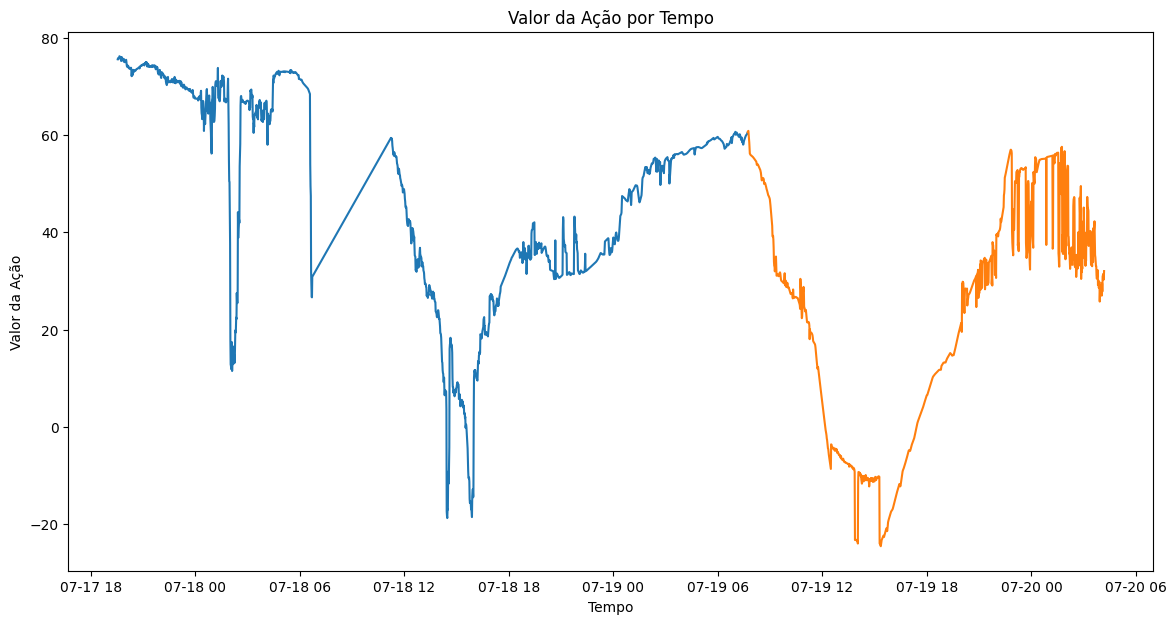

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], actions_value_train, label='Valor da ação - Treinamento')
plt.plot(index[split+1:], actions_value_test, label='Valor da ação - Teste')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.show()

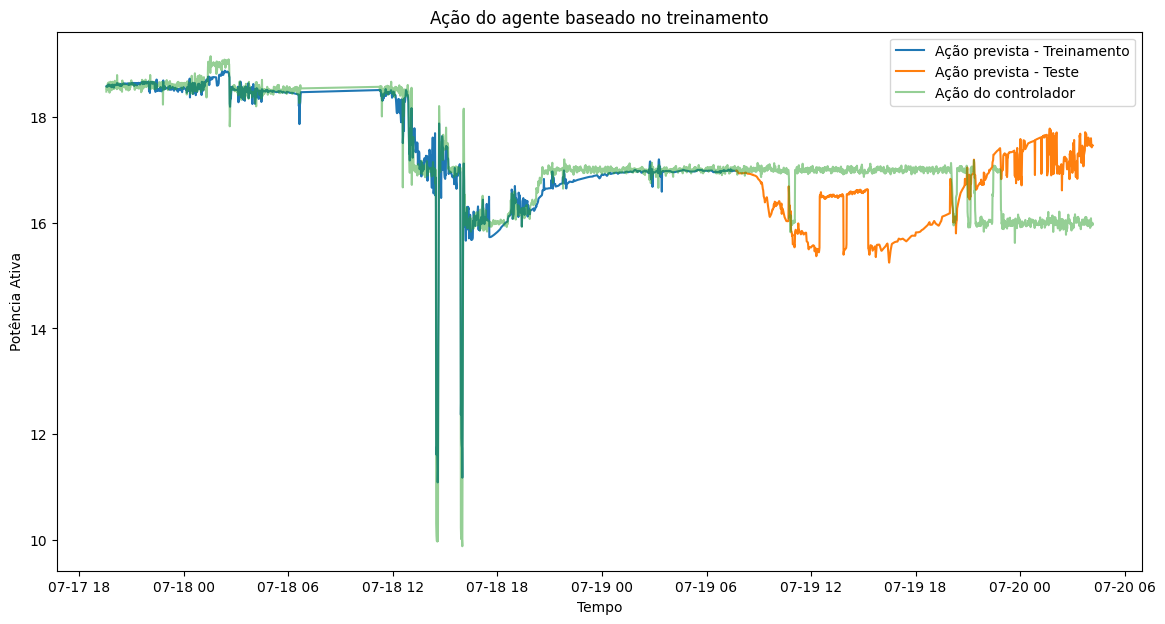

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index[:split+1], predict_actions_train, label='Ação prevista - Treinamento')
plt.plot(index[split+1:], predict_actions_test, label='Ação prevista - Teste')
plt.plot(index, actions, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
metan_agent.save("/content/drive/MyDrive/Conf2/Metano_Agent_60")

In [ ]:
!cp -r /content/d3rlpy_logs/CQL_20240927192546 /content/drive/MyDrive/Conf2/Metano_agent_60%

## Na prática

### Agentes do Hidrogênio e Metano

In [ ]:
hidro_agent = agent(CQLConfig)
hidro_agent.load("/content/drive/MyDrive/Conf2/Hidrogenio_agent_100%/Hidrogenio_Agent_100")

metan_agent = agent(CQLConfig)
metan_agent.load("/content/drive/MyDrive/Conf2/Metano_agent_100%/Metano_Agent_100")

/usr/local/lib/python3.10/dist-packages/d3rlpy/torch_utility.py:345: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load(f, map_location=map_location(self._devi

In [ ]:
observations1_hidro = df_final.loc[:'2024-07-17 19:33:00'].values
observations2_hidro = df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].values
observations3_hidro = df_final.loc['2024-07-20 04:10:00':].values

index_hidro1 = df_final.loc[:'2024-07-17 19:33:00'].index
index_hidro2 = df_final.loc['2024-07-18 06:43:00':'2024-07-18 11:14:00'].index
index_hidro3 = df_final.loc['2024-07-20 04:10:00':].index


observations1_metan = df_final.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].values
observations2_metan = df_final.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].values

index_metan1 = df_final.loc['2024-07-17 19:33:00':'2024-07-18 06:43:00'].index
index_metan2 = df_final.loc['2024-07-18 11:14:00':'2024-07-20 04:10:00'].index

In [ ]:
actions1_hidro = hidro_agent.predict(observations1_hidro)
actions2_hidro = hidro_agent.predict(observations2_hidro)
actions3_hidro = hidro_agent.predict(observations3_hidro)

actions_value1_hidro = hidro_agent.predict_value(observations1_hidro, actions1_hidro)
actions_value2_hidro = hidro_agent.predict_value(observations2_hidro, actions2_hidro)
actions_value3_hidro = hidro_agent.predict_value(observations3_hidro, actions3_hidro)


actions1_metan = metan_agent.predict(observations1_metan)
actions2_metan = metan_agent.predict(observations2_metan)

actions_value1_metan = metan_agent.predict_value(observations1_metan, actions1_metan)
actions_value2_metan = metan_agent.predict_value(observations2_metan, actions2_metan)

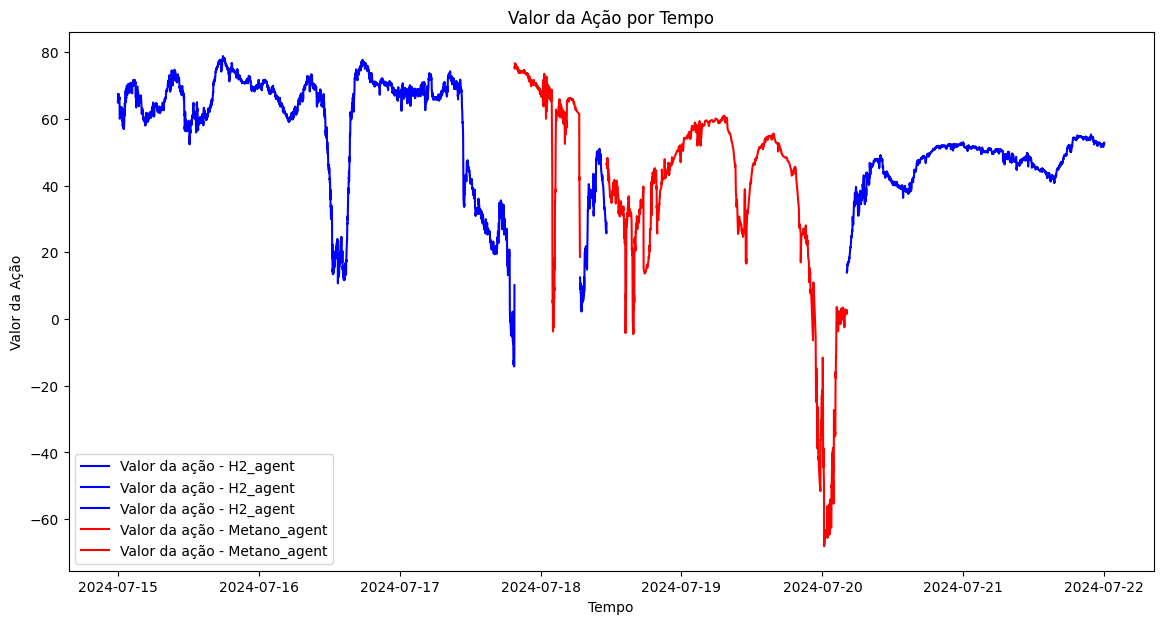

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index_hidro1, actions_value1_hidro, label='Valor da ação - H2_agent', color='blue')
plt.plot(index_hidro2, actions_value2_hidro, label='Valor da ação - H2_agent', color='blue')
plt.plot(index_hidro3, actions_value3_hidro, label='Valor da ação - H2_agent', color='blue')
plt.plot(index_metan1, actions_value1_metan, label='Valor da ação - Metano_agent', color='red')
plt.plot(index_metan2, actions_value2_metan, label='Valor da ação - Metano_agent', color='red')
plt.xlabel("Tempo")
plt.ylabel("Valor da Ação")
plt.title("Valor da Ação por Tempo")
plt.legend()
plt.show()

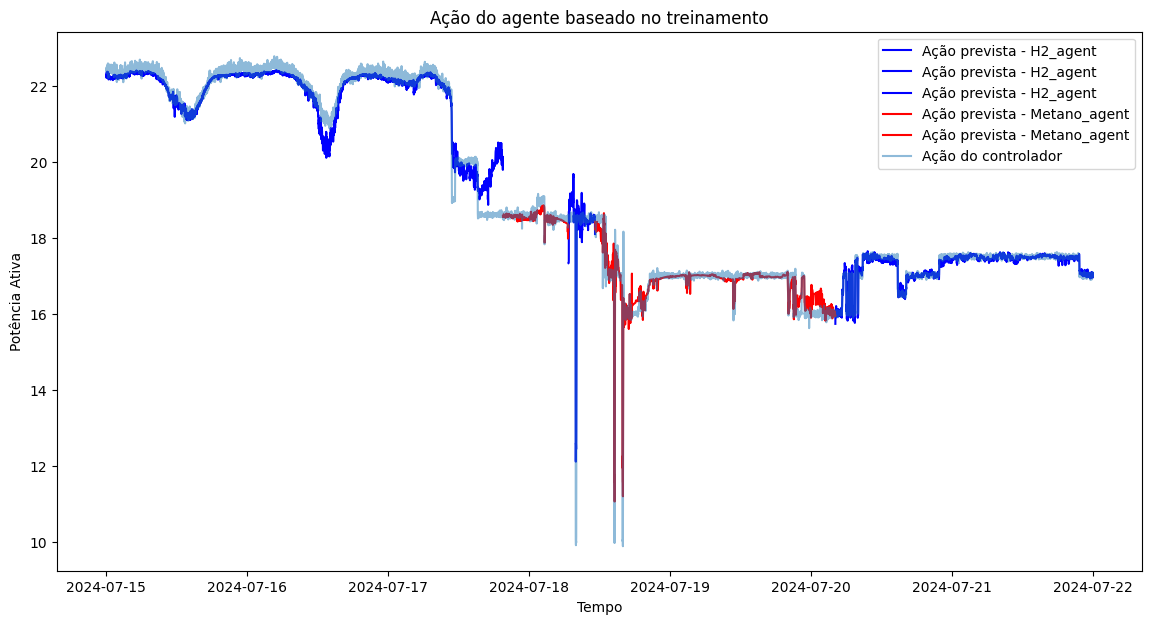

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(index_hidro1, actions1_hidro, label='Ação prevista - H2_agent', color='blue')
plt.plot(index_hidro2, actions2_hidro, label='Ação prevista - H2_agent', color='blue')
plt.plot(index_hidro3, actions3_hidro, label='Ação prevista - H2_agent', color='blue')
plt.plot(index_metan1, actions1_metan, label='Ação prevista - Metano_agent', color='red')
plt.plot(index_metan2, actions2_metan, label='Ação prevista - Metano_agent', color='red')
plt.plot(df_final.index, df_actions["POTENCIA_ATIVA_GERADOR"].values, label='Ação do controlador', alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa")
plt.title("Ação do agente baseado no treinamento")
plt.legend()
plt.show()

In [ ]:
import imageio
import os

# Assuming your data is prepared and available
frames = []
num_frames = 60  # Number of frames for the GIF

# Create a date range based on the index of df_final
date_range = pd.date_range(start=df_final.index[0], end=df_final.index[-1], periods=num_frames)

for i in range(num_frames):
    plt.figure(figsize=(14, 7))
    plt.plot(index_hidro1, actions1_hidro, label='Ação prevista - H2_agent', color='blue')
    plt.plot(index_hidro2, actions2_hidro, label='Ação prevista - H2_agent', color='blue')
    plt.plot(index_hidro3, actions3_hidro, label='Ação prevista - H2_agent', color='blue')
    plt.plot(index_metan1, actions1_metan, label='Ação prevista - Metano_agent', color='red')
    plt.plot(index_metan2, actions2_metan, label='Ação prevista - Metano_agent', color='red')
    plt.plot(df_final.index, df_actions["POTENCIA_ATIVA_GERADOR"].values, label='Ação do controlador', alpha=0.5)

    # Set x-axis limits using datetime values
    plt.xlim(date_range[0], date_range[i])

    plt.xlabel("Tempo")
    plt.ylabel("Potência Ativa")
    plt.title("Ação do agente baseado no treinamento")
    plt.legend()

    # Save frame to a file
    frame_filename = f'frame_{i}.png'
    plt.savefig(frame_filename)
    plt.close()
    frames.append(frame_filename)

# Create GIF
with imageio.get_writer('plot_animation.gif', mode='I', duration=0.1) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Clean up
for frame in frames:
    os.remove(frame)

<ipython-input-17-1d749b360284>:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(date_range[0], date_range[i])
<ipython-input-17-1d749b360284>:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


### Agente único

In [ ]:
full_agent = agent(CQLConfig)
full_agent.load("/content/drive/MyDrive/Conf2/Full_agent_100%/Full_Agent_100")

/usr/local/lib/python3.10/dist-packages/d3rlpy/torch_utility.py:345: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load(f, map_location=map_location(self._devi

In [ ]:
import imageio
import os

# Assuming your data is prepared and available
frames = []
num_frames = 60  # Number of frames for the GIF

# Create a date range based on the index of df_final
date_range = pd.date_range(start=df_final.index[0], end=df_final.index[-1], periods=num_frames)

for i in range(num_frames):
    plt.figure(figsize=(14, 7))
    fig = plt.figure(figsize=(14, 7))
    plt.plot(df_final.index, predict_actions, label='Ação prevista')
    plt.plot(df_final.index, actions, label='Ação do controlador', alpha=0.5)

    # Set x-axis limits using datetime values
    plt.xlim(date_range[0], date_range[i])

    plt.xlabel("Tempo")
    plt.ylabel("Potência Ativa")
    plt.title("Ação do agente baseado no treinamento")
    plt.legend()

    # Save frame to a file
    frame_filename = f'frame_{i}.png'
    plt.savefig(frame_filename)
    plt.close()
    frames.append(frame_filename)

# Create GIF
with imageio.get_writer('plot_animation.gif', mode='I', duration=0.1) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Clean up
for frame in frames:
    os.remove(frame)